# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Load other modules
import tensorflow as tf
import numpy as np
import os
import collections
import sys
import time
import pandas as pd
import cv2

# Load matplotib
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')  # emulates the aesthetics of ggplot (of R)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# TODO: Fill this in based on where you saved the training and testing data

training_file   = './datas/train.p'
validation_file = './datas/valid.p'
testing_file    = './datas/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

def is_subset(a, b):
    '''
    test if b is subset of a
    '''
    b = np.unique(b)
    c = np.intersect1d(a,b)
    return c.size == b.size

# check if any label in valid not in y_train
print('validation-label is subset of train-labels: {}'.format(is_subset(y_train, y_valid)))
print('test-label is subset of train-labels: {}\n'.format(is_subset(y_test, y_valid)))

# summary of training/validation and test sets
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# load signal name
SIGNAMES = pd.read_csv('./signnames.csv')['SignName']

validation-label is subset of train-labels: True
test-label is subset of train-labels: True

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


We code some helper code in `pipeline` to facilitate the task of pre-processing data and network creation

In [152]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

from pipeline.data import BaseTransform, StandardTransform, AugmentTransform, \
                          TransformPipeline, Minibatch, Dataset, label_to_indices
from pipeline.nn import NeuralNetwork
from pipeline.train import TrainingSession

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [200]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import textwrap

def show_img(img, label, signame = None, cmap = None, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        if signame is not None:
            wrapped_signame = '\n'.join(textwrap.wrap(signame, width=30))
            label = '{}\n{}'.format(label, wrapped_signame)
        
        ax.text(0, 0, label, color='k',backgroundcolor='c', fontsize=8)
    
    ax.imshow(img, cmap = cmap)
    ax.axis('off')  
    
def grid_view(imgs, labels, signames = None, cmaps = None, ncols = 3, figsize = (8, 15)):
    '''
    this function draw a grid of images & labels
    '''
    nrows = (len(imgs) + ncols - 1) // ncols
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)
        
    for i, ax in enumerate(axes.flatten()):
        
        if i < len(imgs):
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            signame = None if signames is None else signames[labels[i]]
            cmap = None if cmaps is None else cmaps[i]
            show_img(imgs[i], labels[i], signame = signame, cmap = cmap, ax = ax)
        else:
            ax.axis('off')

def visualize_traffic_signs(inputs, labels, figsize = (15, 25)):
    '''
    this function draws one sign per label for all labels
    '''
    _, labels_map = label_to_indices(labels)
    
    imgs = []
    labels = []

    for i in range(n_classes):
        indices = labels_map.get(i, [])
        count = len(indices)
        if count > 0:
            idx = indices[np.random.randint(count)]
            imgs.append(inputs[idx])
            
            labels.append('Label {} (#{})\nSample {}-th'.format(i, count, idx))
    
    grid_view(imgs, labels, SIGNAMES, ncols=5, figsize = figsize)
        

def histogram(y, title):
    bins = np.arange(np.max(y) + 1) - 0.5
    hist, bins = np.histogram(y, bins=bins)
    
    plt.figure()
    plt.hist(y, bins=bins)
    plt.title(title)
    plt.text(45, 0.5*np.max(hist), 'min-count = {}\nmax-count = {}'.format(np.min(hist),
                                                                           np.max(hist)))
    plt.show()

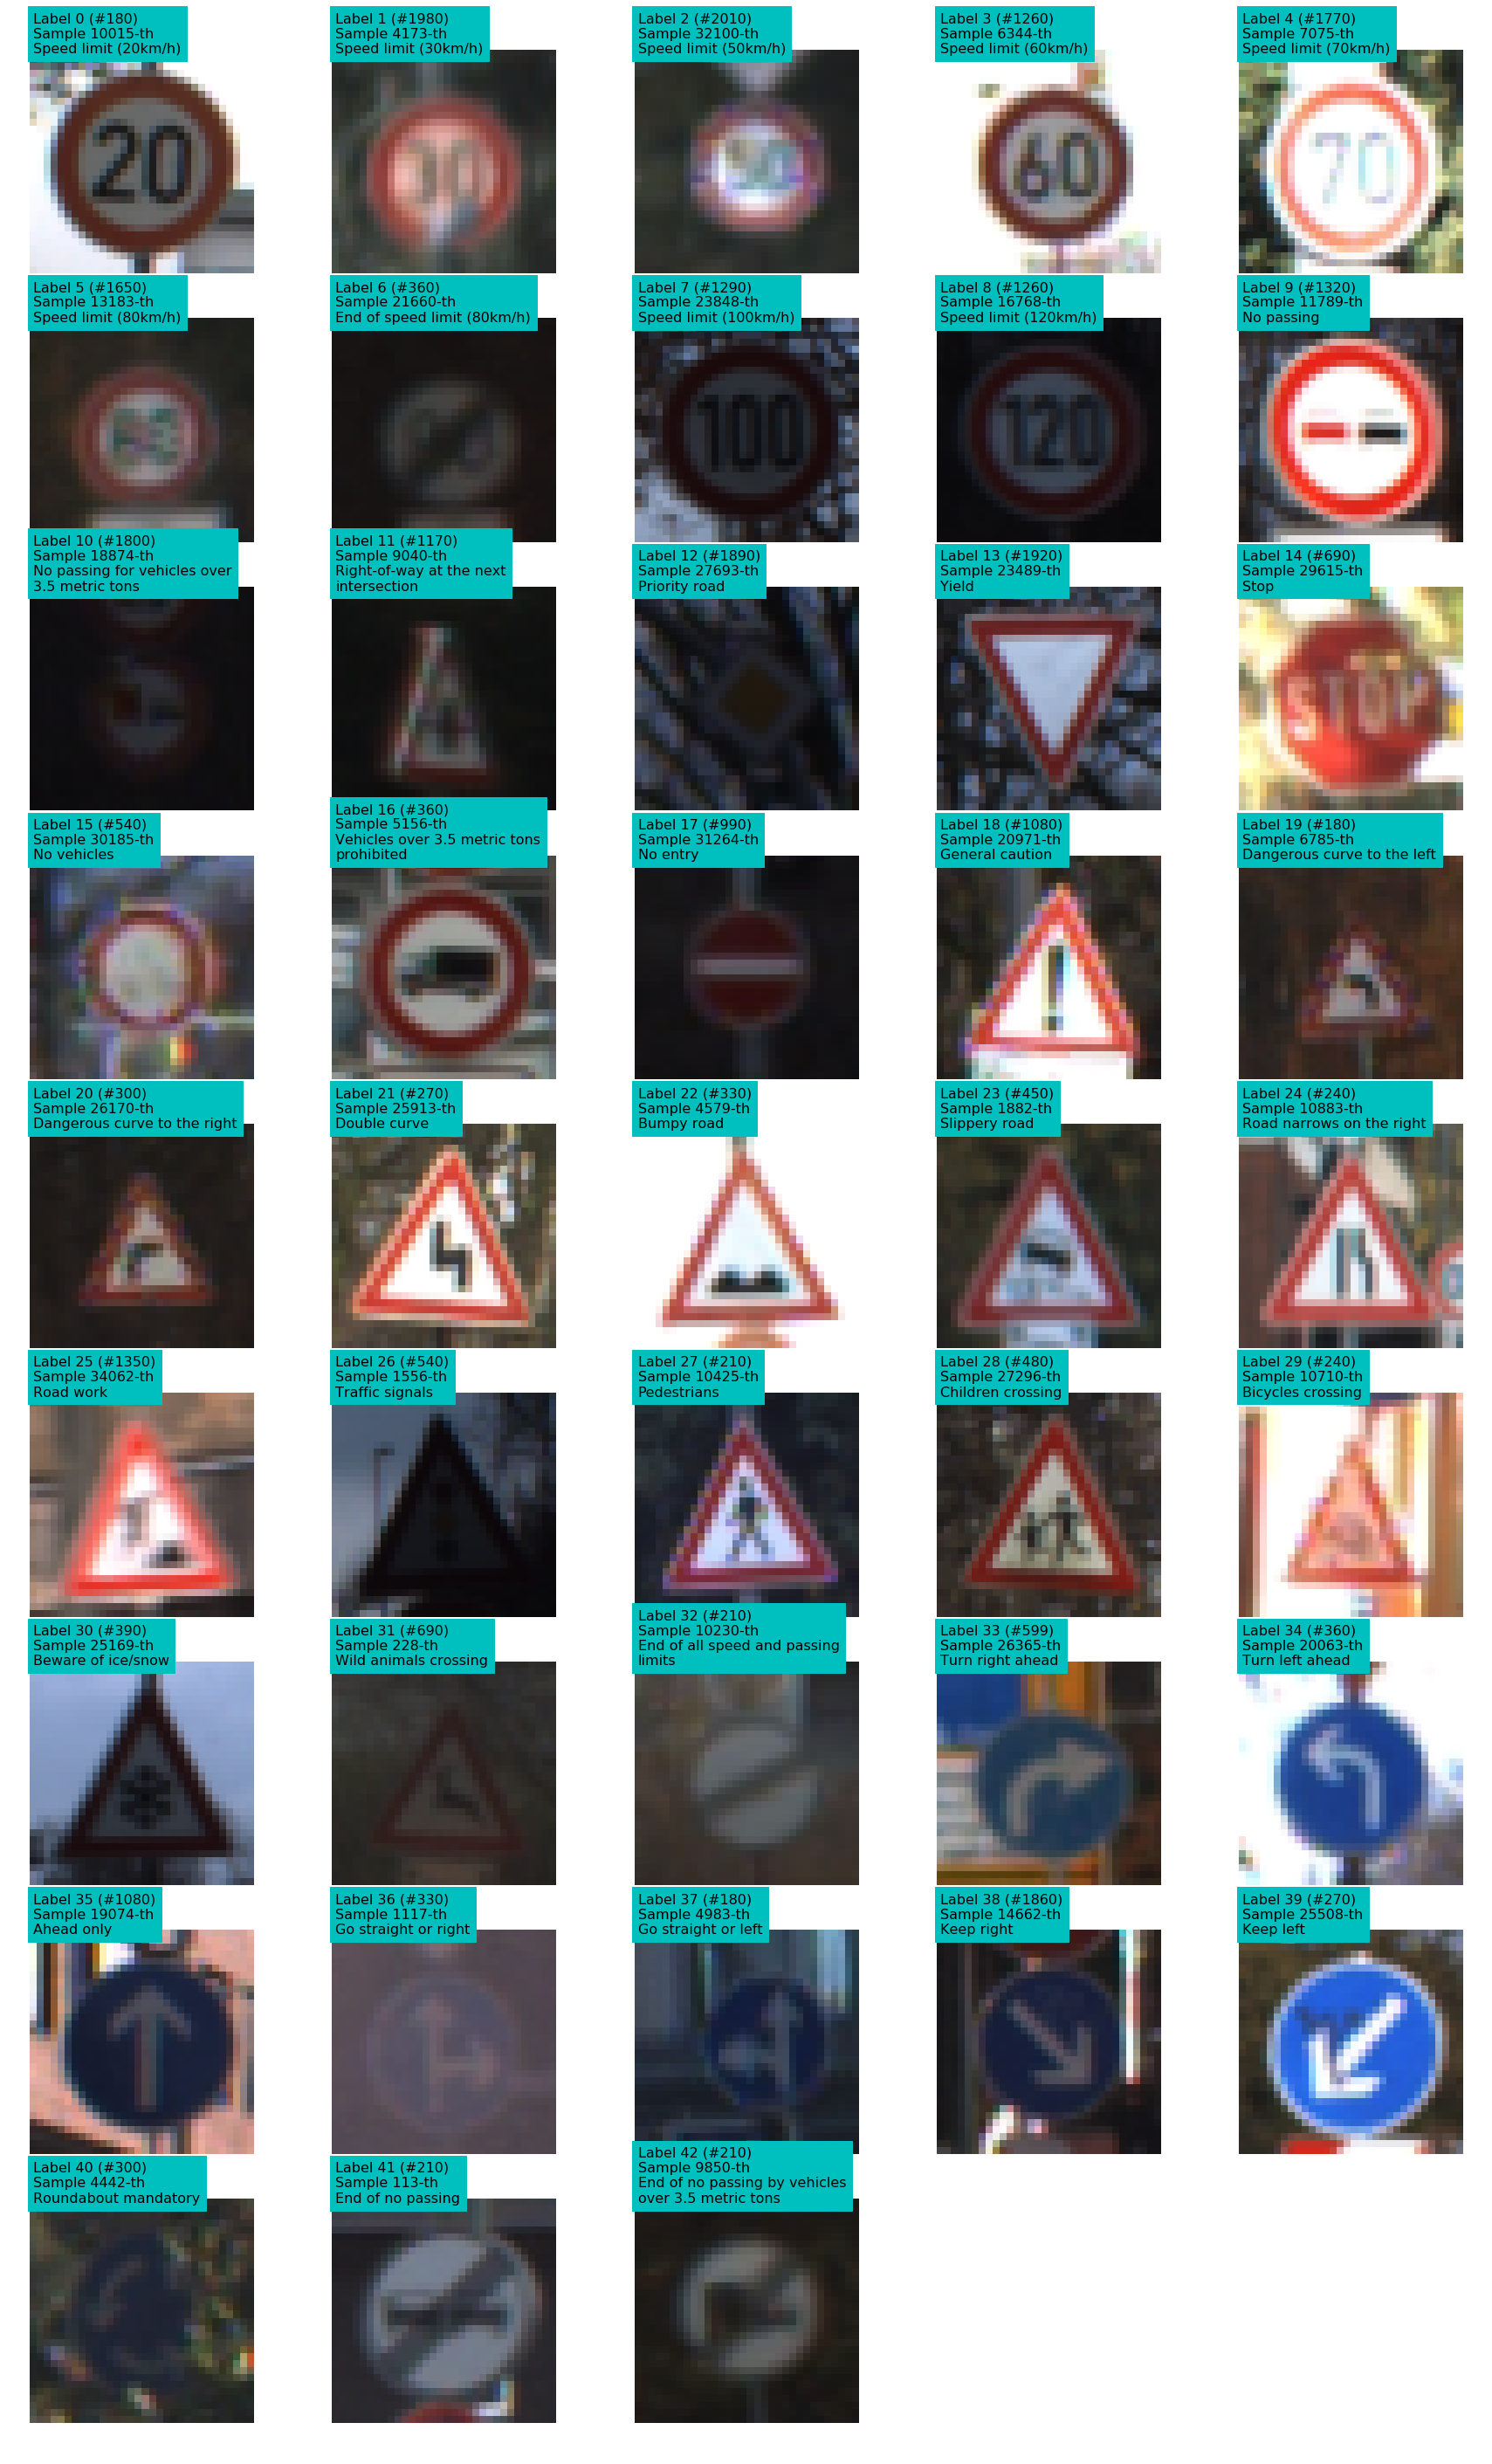

In [75]:
# visualize some traffic-sign & label
visualize_traffic_signs(X_train, y_train)

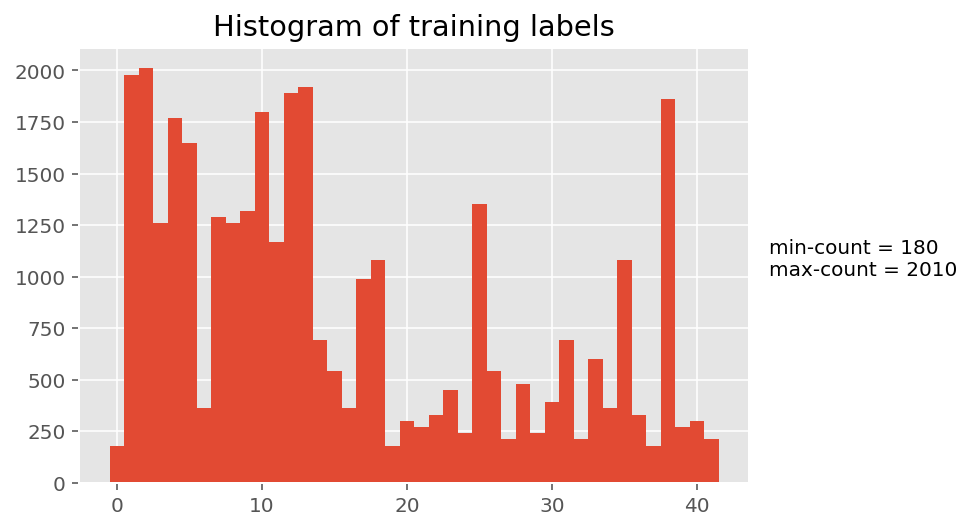

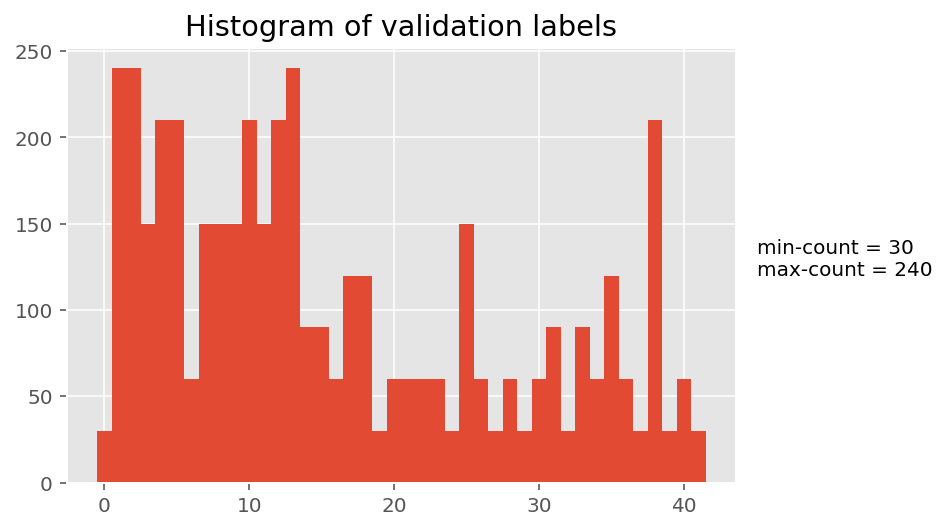

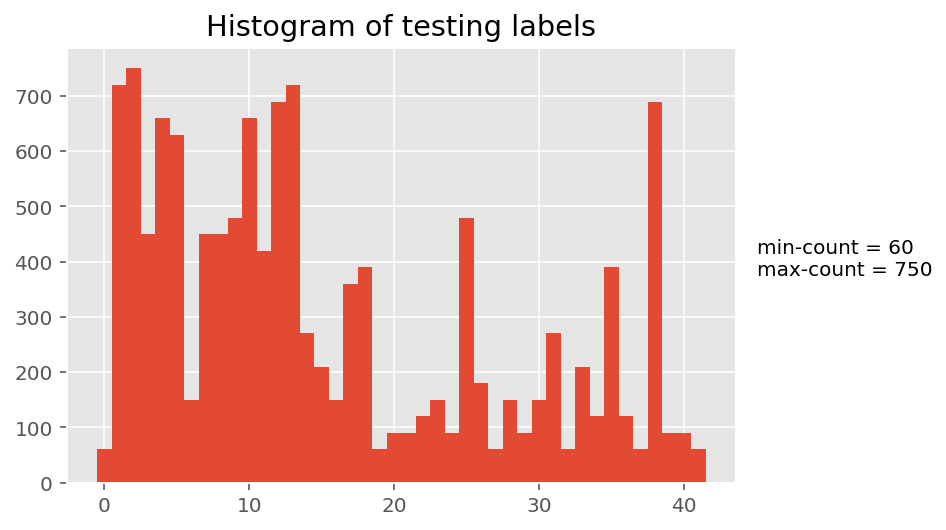

In [6]:
# visualize histogram of labels
histogram(y_train, 'Histogram of training labels')
histogram(y_valid, 'Histogram of validation labels')
histogram(y_test, 'Histogram of testing labels')

Looking at above data we observe two things
* some input images is realy dark
* the number of samples per class is not uniformly distributed: some labels with less than 200 samples (label 0 has 180 samples), and some with more than 1000 samples (label 2 has 2010 samples)

From this observation, in the pre-processing data we will look at
* convert image into other color-space for example gray-scale since traffic-sign can be recognized via shape
* augment training input to make it balanced out

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### Data augmentation
Examine the dataset we notice that
* some labels have a lot of training e.g label 2 (speed-limit-50) with 2010 samples
* some labels have few samples e.g label 0 (speed-limit-20) with only 180 samples.

In the baseline model, it builds a jttered dataset by doing
* translate in position: [-2, 2] pixels
* scale [.9, 1.1] ratio
* rotation [-15, +15]

Here we will use *rotation* and *projection transformations* (which is a combination of shearing and scaling)

In [7]:
from skimage import transform

def rotate(img, max_degree = 10.0):
    return transform.rotate(img, np.random.uniform(-max_degree, max_degree), mode = 'edge')

def project(img, max_pixel = 5.0):
    # random generate 4 corners: top-left, bottom-left, bottom-right, top-right    
    tl, bl, br, tr = np.random.uniform(-max_pixel, max_pixel, size = [4, 2])
    
    image_size = 32
    
    bl[1] = image_size - bl[1]
    br    = image_size - br    
    tr[0] = image_size - tr[0]
    
    # projection
    trans_obj = transform.ProjectiveTransform()
    trans_obj.estimate(np.array([
            tl,
            bl,
            br,
            tr]), np.array([
            [0, 0],
            [0, image_size],
            [image_size, image_size],
            [image_size, 0]]))
    
    return transform.warp( img, 
                           trans_obj, 
                           output_shape=(image_size, image_size), 
                           order = 1, 
                           mode = 'edge')

def jitter(img):
    img = rotate(img)
    img = project(img)
    img *= 255.0
    return np.ceil(img).astype(np.uint8)

Let's try the transformation on some images

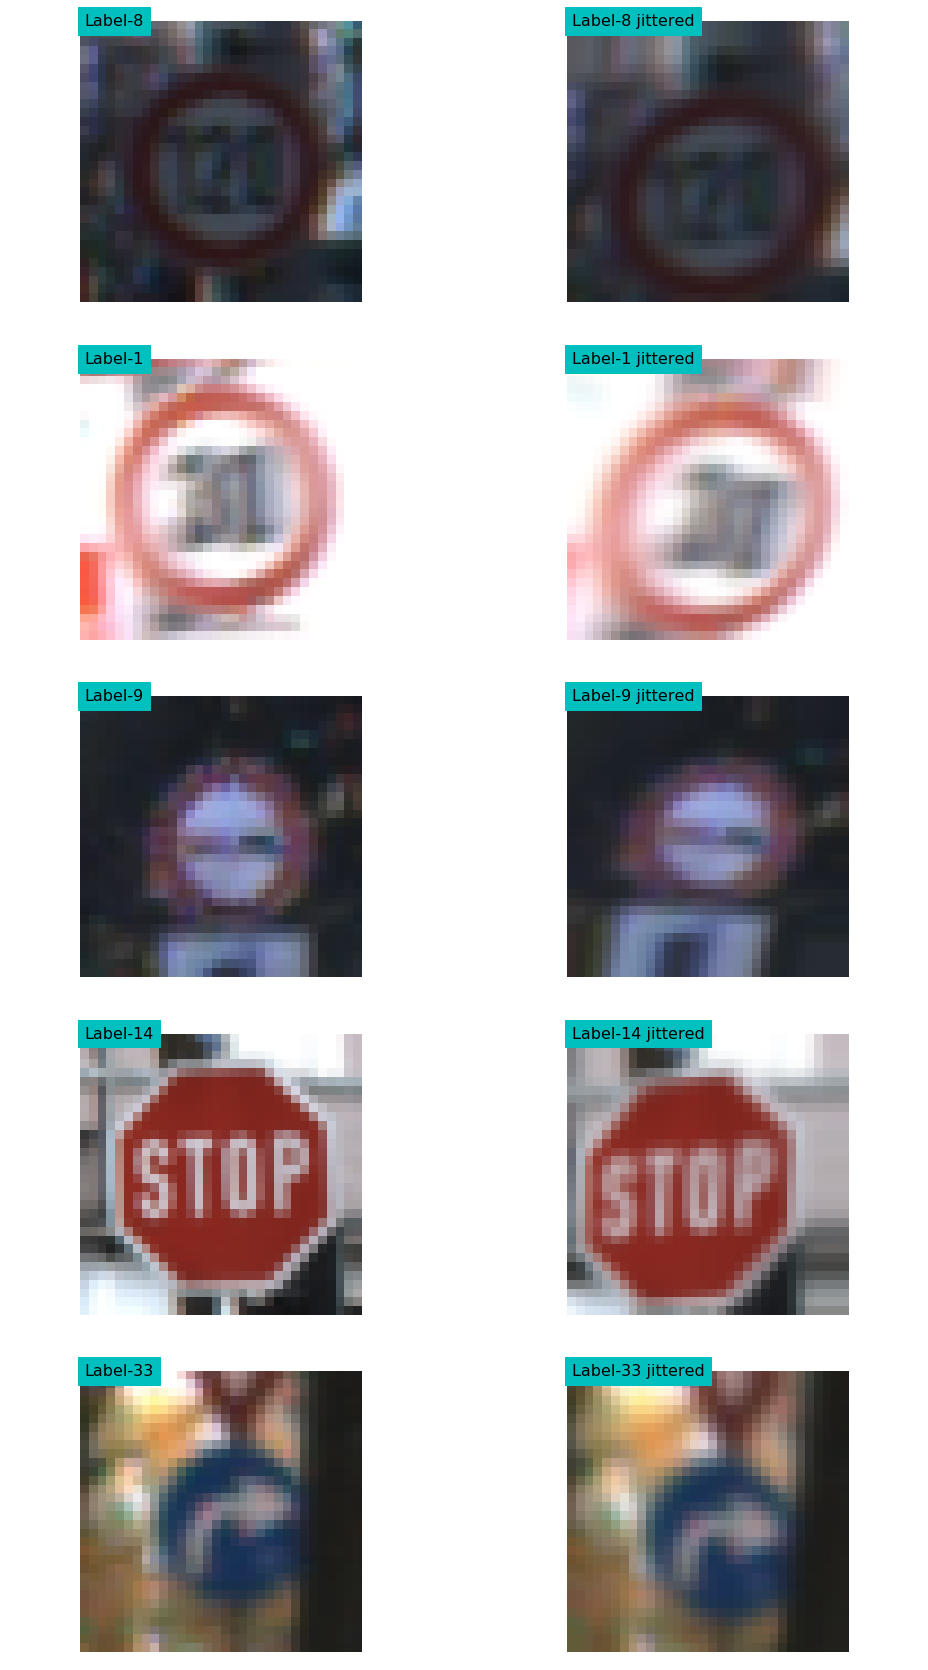

In [8]:
imgs = []
labels = []
for i in range(5):
    idx = np.random.randint(X_train.shape[0])
    img = X_train[idx]        
    jittered_img = jitter(img)
    
    imgs += [img, jittered_img]
    label = 'Label-{}'.format(y_train[idx])
    labels += [label, '{} jittered'.format(label)]

grid_view(imgs, labels, ncols=2)

#### RGB vs other color-space
As suggested in the baseline model's paper that grayscale image works better so we try two following steps:
* RGB to YUV
* RGB to Y (gray-scale)

In [9]:
scale01 = lambda x : x / 255
rbg_y_converter = lambda x : cv2.cvtColor(x, cv2.COLOR_RGB2YUV)[:,:,0:1] # we keep last-dim since 
                                                                         # our network expect 3d-input

# scale transformer
trans_scale = BaseTransform(transform_func=scale01)

# color transformer
trans_rgb_y = BaseTransform(transform_func=rbg_y_converter)

# normalized transformer
trans_standard = StandardTransform()

Let's view some dark images in gray-scale

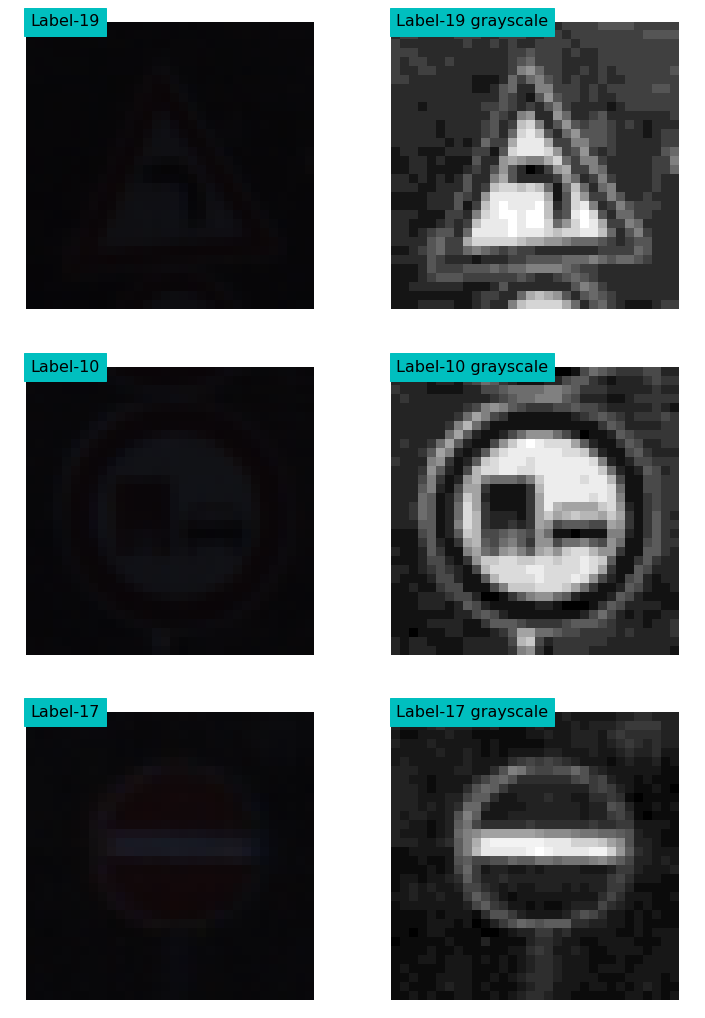

In [10]:
dark_indices = [6647, 17455, 30570]
imgs   = []
labels = []
cmaps  = []
for dark_idx in dark_indices:
    img = X_train[dark_idx]
    label = 'Label-{}'.format(y_train[dark_idx])
    y_img = rbg_y_converter(img)[:,:,0]
    imgs += [img, y_img]    
    labels += [label, '{} grayscale'.format(label)]
    cmaps += [None, 'gray']

grid_view(imgs, labels, cmaps=cmaps, ncols=2, figsize=(6,3*len(dark_indices)))

One can see that grayscale images is much esier for human perception.

#### Data normalization

From the paper [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf), it suggests that normalized inputs (mean zero and stddev one) might help the model trains faster so we implemente it in `data.py` in the class `StandardTransform`

#### Data pipeline

Mimic the pipeline from [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), we implement `TransformPipeline` in `data.py` to facilitate the following tasks

* augment original-data
* convert original-data to yuv/y
* normalized data

In [11]:
# augmentation transformer
trans_aug_5x = AugmentTransform(jitter_func=jitter,
                                augtype = 'jitter', 
                                auglevel = 4)    # use original input + generate 4x jittered-dataset
                                                      # to create 5x original_input dataset 

trans_aug_3k = AugmentTransform(jitter_func=jitter,
                                augtype = 'jitter_balance',
                                auglevel = 3000) # use original input + generate (3000-num_oringal_input) additional one
                                                      # to make each label has 3000 samples

# augmented data -> yuv/y -> then normalized
aug_pipeline_5x = TransformPipeline([trans_aug_5x])
aug_pipeline_3k = TransformPipeline([trans_aug_3k])

We are ready to generate our augmented data 

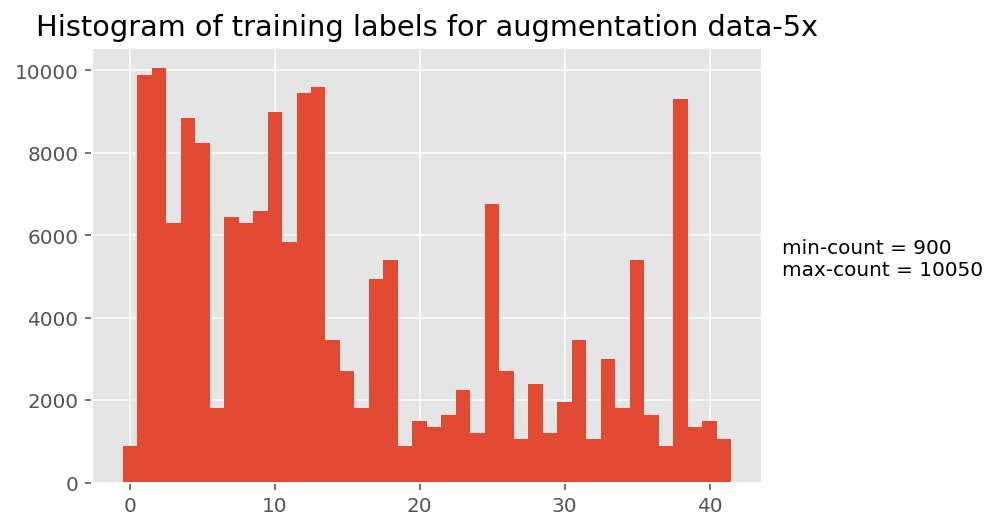

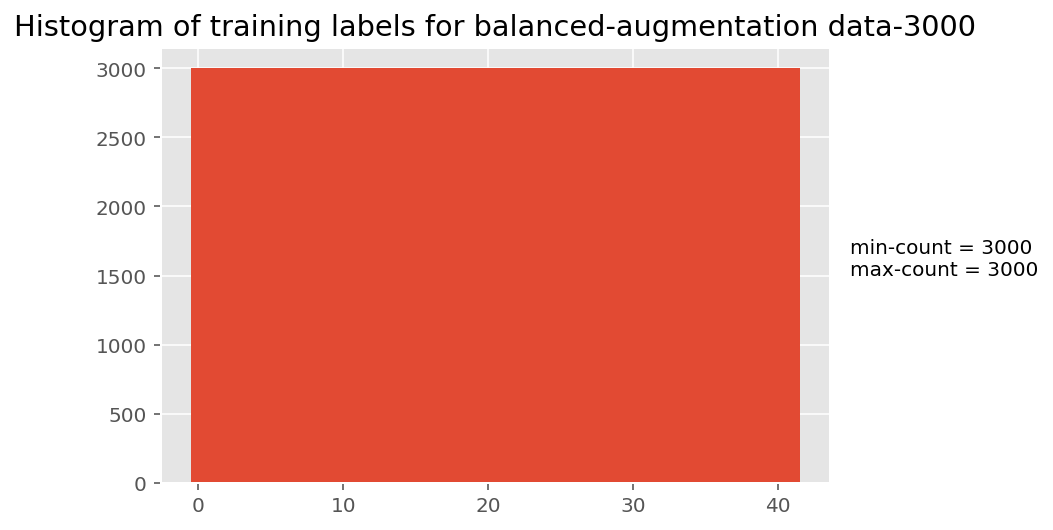

In [12]:
# turn it on if we want to re-generate
regen = False

# do augment, then rbg -> yuv then pickle file
def aug_trans_and_pickle(filename, data_pipeline, inputs, labels, regen = False):
    if os.path.isfile(filename) and not regen:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            return data['features'], data['labels']
    
    new_inputs, new_labels = data_pipeline.fit_and_transform(inputs, labels)
    with open(filename, 'wb') as f:
        pickle.dump({'features' : new_inputs, 'labels' : new_labels}, f)
    
    return new_inputs, new_labels

X_train_5x, y_train_5x = aug_trans_and_pickle('./datas/train_5x.p', aug_pipeline_5x, 
                                                  X_train, y_train, regen = regen)
X_train_3k, y_train_3k = aug_trans_and_pickle('./datas/train_3k.p', aug_pipeline_3k, 
                                                  X_train, y_train, regen = regen)

histogram(y_train_5x, 'Histogram of training labels for augmentation data-5x')
histogram(y_train_3k, 'Histogram of training labels for balanced-augmentation data-3000')

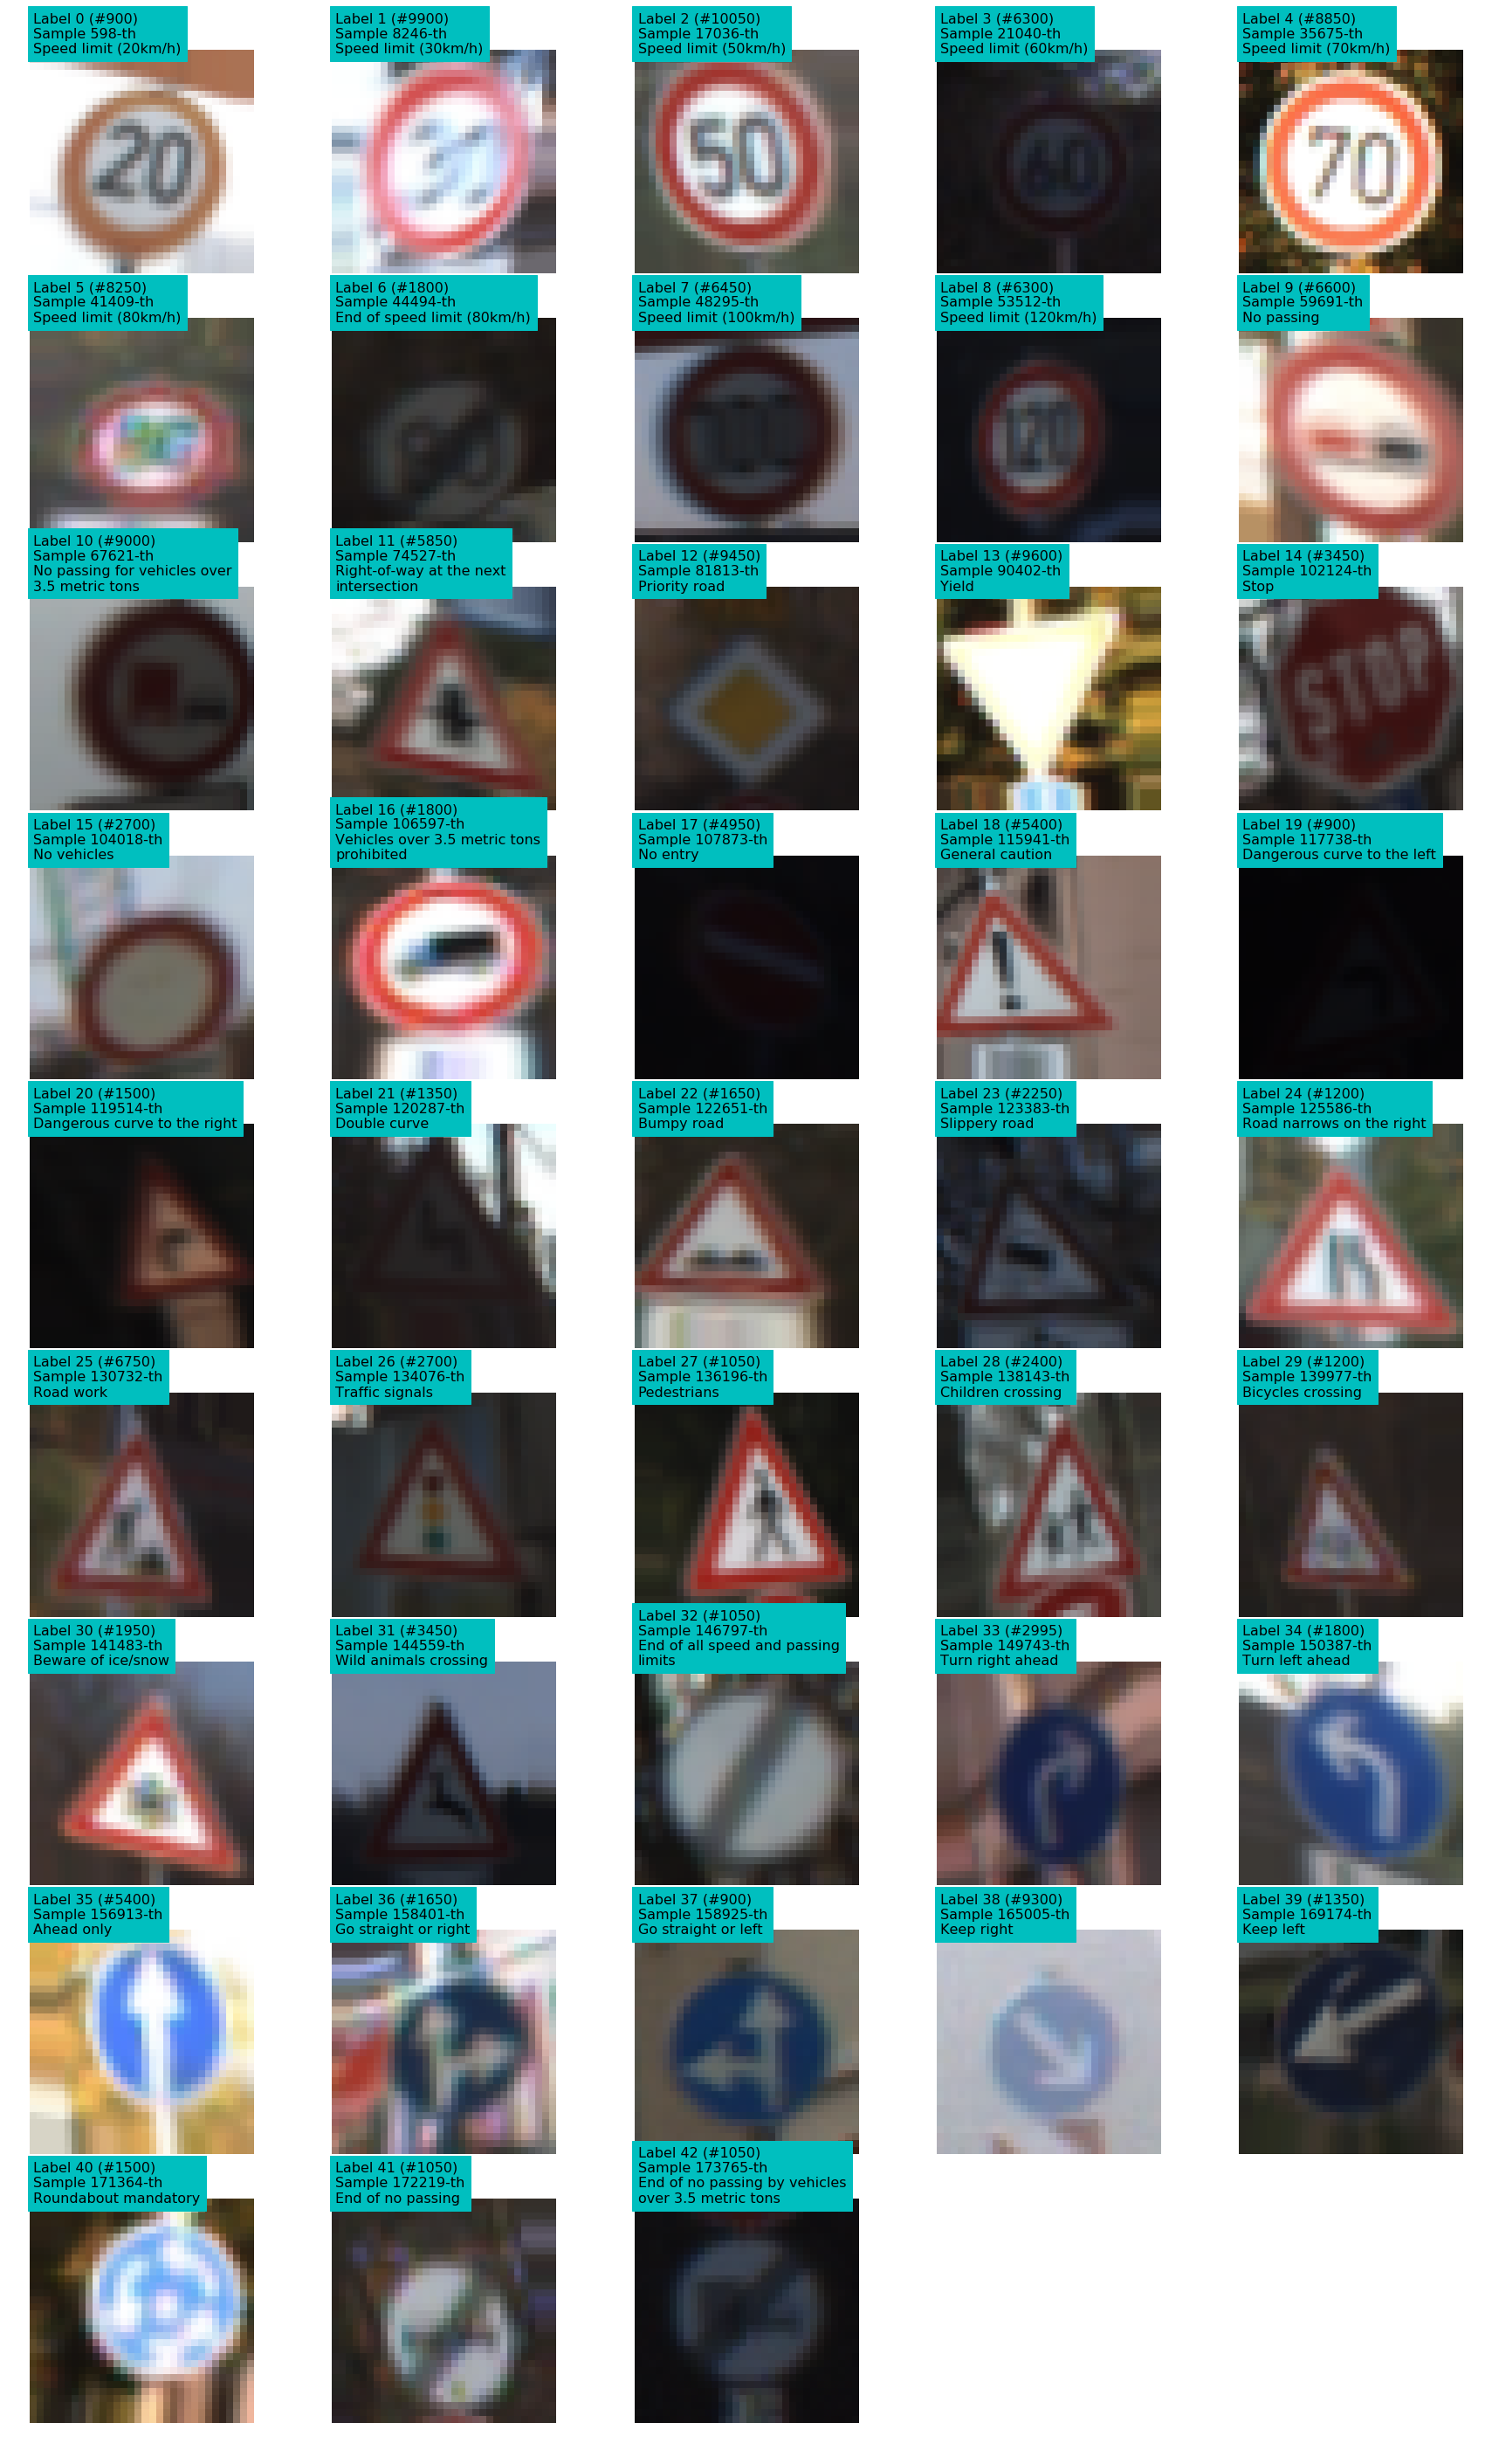

In [13]:
visualize_traffic_signs(X_train_5x, y_train_5x)

We also make a function to create `Dataset` object to allow us 
* apply transformation-pipeline to data
* generate mini-batches for training and testing

In [14]:
# helper function to make dataset from original-data or augmented one
def make_dataset(data_pipeline, src = 'original', jitter_func = None):
    if src not in ['original', 'aug_5x', 'aug_3k']:
        raise Exception('src must be original, aug_5x, aug_3k')
    
    if src == 'original':
        return Dataset(data_pipeline, 
                       training_set = (X_train, y_train), 
                       validation_set = (X_valid, y_valid),
                       test_set = (X_test, y_test), 
                       jitter_func = jitter_func) # we only allow original data to be jittered each epochs
    elif src == 'aug_5x':
        return Dataset(data_pipeline, 
                       training_set = (X_train_5x, y_train_5x), 
                       validation_set = (X_valid, y_valid),
                       test_set = (X_test, y_test))
    elif src == 'aug_3k':
        return Dataset(data_pipeline, 
                       training_set = (X_train_3k, y_train_3k), 
                       validation_set = (X_valid, y_valid),
                       test_set = (X_test, y_test))

### Model Architecture
As suggested in the project, the Lenet-5 could give accuracy ~ 89%, so we will try it in this project and try to improve it.

[model_lenet]: ./assets/model01_lenet.png "Model architcture LeNet"

![alt text][model_lenet]


Also, from the baseline model's paper, the model that uses only grayscale-channel `Y`, has the following architecture

[model_ms]: ./assets/model02_multiscale.png "Model architcture Multi-scale"

![alt text][model_ms]

This model looks similar as the architecture of `Lenet 5` with only addtional is the multi-scale layers. To facilitate the task of ensemble a Neural Network for classifier, we code a wrapper class `NeuralNetwork` in `nn.py`

#### Neural Network 1
The first network has LeNet's architecture with the following main modification
* we allow both RGB-input (32x32x3) or gray-scale Y-input (32x32x1)
* we use relu as activation (instead of sigmoid)

It's architecture is given below
* 2-conv-net layers with 8-16 channels (8 for the first one, 16 for the second one) each with relu-actiavtion
* max-pool (2,2) after activation
* single-scale feature before the fully-connceted layer
* 2-fully-connected layers with 120/84 hidden units
* output-layer is logits with 43 output

The net can be created as following

In [15]:
def make_network_1(input_shape):
    return (NeuralNetwork()
                    .input(input_shape) 
                    .conv(ksize=(5, 5), out_channels=8, padding='VALID') 
                    .max_pool(ksize=2, stride=2)              
                    .conv(ksize=(5, 5), out_channels=16, padding='VALID')  
                    .max_pool(ksize=2, stride=2)              
                    .flatten()
                    .dense(120)
                    .dense(84)
                    .classifier(n_classes))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Given a network and datasets (training/validation and test datasets), the training is done by
* create a loss function e.g for classifier we can use `tf.nn.softmax_cross_entropy_with_logits`)
* create an optimizer e.g `tf.train.AdamOptimizer`
* run mini-batches update on given datasets
* after each epoch, evaluate training-accuracy vs validation-accuracy
* after all training, we evaluate model's accuracy on test dataset

In [62]:
DEFAULT_HYPERPARAMS = {'learning_rate'    : 1e-3,
                       'batch_size'       : 64,
                       'epochs'           : 10,
                       'print_every'      : 1,
                       'debug'            : False,
                       'early_stopping'   : False,
                       'early_checkpoint' : None}

def train_evaluate(training_session, dataset, **hyperparams):
    learning_rate = hyperparams.get('learning_rate', DEFAULT_HYPERPARAMS['learning_rate'])
    batch_size    = hyperparams.get('batch_size', DEFAULT_HYPERPARAMS['batch_size'])
    epochs        = hyperparams.get('epochs', DEFAULT_HYPERPARAMS['epochs'])
    debug         = hyperparams.get('debug', DEFAULT_HYPERPARAMS['debug'])
    print_every   = hyperparams.get('print_every', DEFAULT_HYPERPARAMS['print_every'])
    
    # we store the session's state when validation-accuracy is the best
    early_stopping   = hyperparams.get('early_stopping', DEFAULT_HYPERPARAMS['early_stopping'])
    early_checkpoint = hyperparams.get('early_checkpoint', DEFAULT_HYPERPARAMS['early_checkpoint'])
    
    if early_stopping:
        if early_checkpoint is None:
            raise Exception('Must provide early_checkpoint when early_stopping is enabled')
    
        early_checkpoint = os.path.join('./checkpoints/', early_checkpoint)
    
    # init learning-rate
    training_session.init_optimizer(learning_rate)

    # training-loop
    step = 0
    learning_curve = []
    train_start = time.time()
    
    # keep track of best validation accuracy
    best_val = 0.8
    
    for e in range(epochs):
        running_cost = 0.
        num_iter = 0
        start = time.time()
        for inputs, labels in dataset.get_training_batches(batch_size):
            _, cost = training_session.train_and_evaluate_cost(inputs, labels)
            num_iter += 1
            step+=1
            running_cost += cost
            if debug:
                sys.stdout.write('\rEpoch ({:>3d}/{:<3d}) '.format(e + 1, epochs) +
                                   'Iteration {:>5d} '.format(step + 1) +
                                   'Lost {:>6.3f} '.format(running_cost / num_iter))
        
        # evaluate training-accuracy + validation-accuracy
        train_acc = training_session.score(dataset.train_set, batch_size)
        val_acc   = training_session.score(dataset.val_set, batch_size)
        
        if debug: print('\n', end='')
        
        end = time.time()
        if (e == 0 or ((e + 1) % print_every) == 0):
            print('Epoch ({:>3d}/{:<3d})'.format(e + 1, epochs),
                  'Training-accuracy     {:5.2f}%'.format(100. * train_acc),
                  '\tValidation-accuracy {:5.2f}%'.format(100. * val_acc),
                  '\tRunning {:.2f} seconds/batch'.format(end - start))
        
        learning_curve.append([train_acc, val_acc])
        
        if early_stopping and val_acc > best_val:
            best_val = val_acc
            training_session.save(early_checkpoint)
            
    train_end = time.time()
    
    
    if early_stopping:
        print('Load session\'state from {}'.format(early_checkpoint))
        training_session.load(early_checkpoint)
        
        # evaluate training-accuracy + validation-accuracy using early-stopping section
        train_acc = training_session.score(dataset.train_set, batch_size)
        val_acc   = training_session.score(dataset.val_set, batch_size)
    
    # evaluate test-accuracy
    test_acc = training_session.score(dataset.test_set, batch_size)
    
    print('\nTraining is done in {:.2f} seconds'.format(train_end - train_start),
          '\n\tTraining-accuracy:   {:5.2f}%'.format(100.0 * train_acc),
          '\n\tValidation-accuracy: {:5.2f}%'.format(100.0 * val_acc),
          '\n\tTesting-accuracy:    {:5.2f}%'.format(100.0 * test_acc))
    
    return pd.DataFrame(learning_curve, index = np.arange(1, epochs+1), columns=['train-accuracy', 'val-accuracy'])

### Experiment

In this section, first we evaluate some data-preprocessing pipeline for e.g
* RGB or Y
* Normalized input or not e.t.c

We create a helper function for doing this

In [17]:
from matplotlib.ticker import FuncFormatter

def draw_learning_curve(learning_curves, base_levels = [.93]):
    for title, learning_curve in learning_curves:
        ax = learning_curve.plot(y = ['train-accuracy', 'val-accuracy'])
        # draw base-level
        for base_level in base_levels:
            ax.plot(learning_curve.index.values[[0, -1]], 
                    [base_level, base_level], 
                    label = '{:.2f} %'.format(100*base_level))
        
        ax.set_xlabel('epochs')
        ax.set_ylabel('accuracy (%)')
        ax.set_ylim([0.8,1.01])
        ax.legend()
        # convert accuracy -> percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
        ax.set_title(title)

def evaluate_pipeline(pipelines, make_net, src = 'original', jitter_func = None, **kwargs):
    '''
    helper function evaluate pipelines 
    '''
    learning_curves = []
    for i, (dp_name, dp) in enumerate(pipelines):
        dataset = make_dataset(dp, src, jitter_func = jitter_func)        
        net = make_net(dataset.input_shape())
        
        print('--------------------------------------')
        print('Evaluate data pipeline {}'.format(dp_name))
        print('--------------------------------------')
        with TrainingSession(net) as sess:
            learning_curve = train_evaluate(sess, dataset = dataset, **kwargs)
        print('--------------------------------------\n')
        learning_curves.append(['Learning curve for {}'.format(dp_name), learning_curve])
        
    return learning_curves

#### Experiment 1: RGB or Y (gray-scale)
First let's experiment with various data-preprocessing pipeline using the same model + original data

* pipeline 1: keep RGB
* pipeline 2: convert RGB to Y (gray-scale)

Note that input is uint8, so we always need to scale it to small number for example by dividing it to 255.

In [18]:
# rgb / 255
data_pipeline_1 = TransformPipeline([trans_scale])    

# y / 255
data_pipeline_2 = TransformPipeline([trans_rgb_y, trans_scale])    

learning_curves = evaluate_pipeline([('rgb/255',    data_pipeline_1), 
                                     ('rgb->y/255', data_pipeline_2)],
                                    make_network_1, epochs = 20)

--------------------------------------
Evaluate data pipeline rgb/255
--------------------------------------
Epoch (  1/20 ) Training-accuracy     84.85% 	Validation-accuracy 78.71% 	Running 4.74 seconds/batch
Epoch (  2/20 ) Training-accuracy     94.68% 	Validation-accuracy 85.35% 	Running 3.60 seconds/batch
Epoch (  3/20 ) Training-accuracy     97.03% 	Validation-accuracy 87.96% 	Running 3.10 seconds/batch
Epoch (  4/20 ) Training-accuracy     97.70% 	Validation-accuracy 88.57% 	Running 2.80 seconds/batch
Epoch (  5/20 ) Training-accuracy     98.45% 	Validation-accuracy 89.64% 	Running 3.24 seconds/batch
Epoch (  6/20 ) Training-accuracy     98.25% 	Validation-accuracy 89.98% 	Running 2.95 seconds/batch
Epoch (  7/20 ) Training-accuracy     98.07% 	Validation-accuracy 91.18% 	Running 2.64 seconds/batch
Epoch (  8/20 ) Training-accuracy     98.32% 	Validation-accuracy 90.41% 	Running 2.76 seconds/batch
Epoch (  9/20 ) Training-accuracy     99.40% 	Validation-accuracy 92.11% 	Running 2

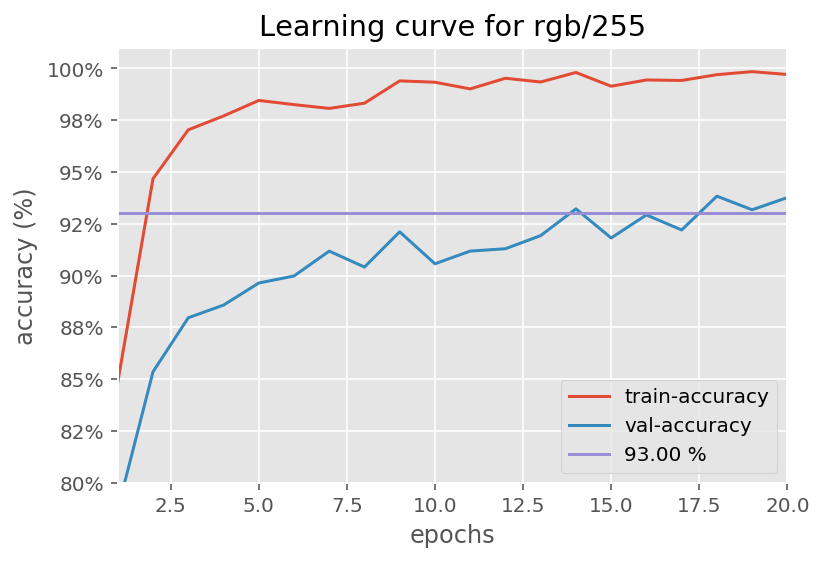

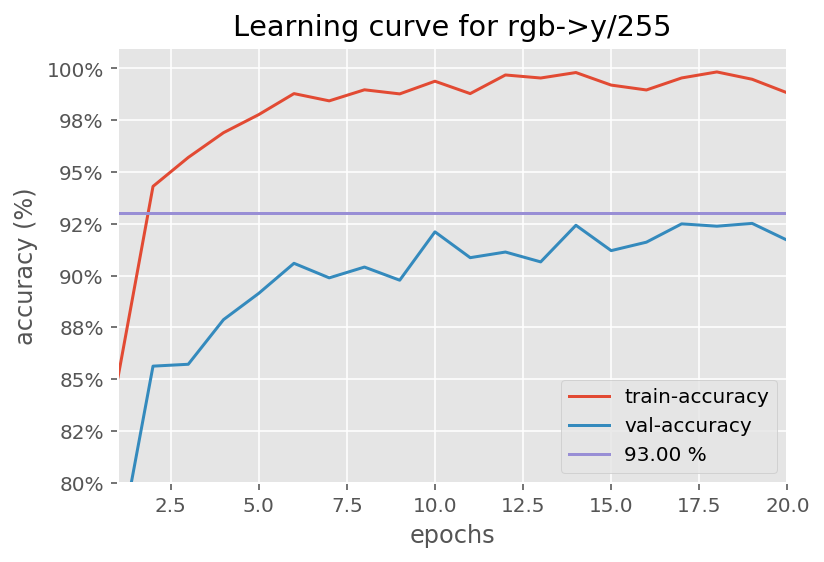

In [19]:
draw_learning_curve(learning_curves)

Looking at above result, we observe

* for all data-pipelines, our model is well overfitting
* using only Y-channel is slightly less accuracy than  RGB but it's faster

Since using RGB gives slightly better accuracy, we will keep using RGB from now on (note this is against what stated in the baseline-model papers but here we use different net's architecture, we will test Y-channel only later).

#### Experiment 2: Normalized data or not?

Now look at RGB images, we want to check whether normalized inputs can helps? Also we reduce number of epochs to 15 since after 15 epochs our model is well overfitting and validation-accuracy is not improved

In [20]:
# (rgb - mean)/std
data_pipeline_3 = TransformPipeline([trans_standard])

learning_curves = evaluate_pipeline([('rgb/255',        data_pipeline_1), 
                                     ('(rgb-mean)/std', data_pipeline_3)],                                     
                                      make_network_1, epochs = 15)

--------------------------------------
Evaluate data pipeline rgb/255
--------------------------------------
Epoch (  1/15 ) Training-accuracy     87.01% 	Validation-accuracy 78.48% 	Running 4.21 seconds/batch
Epoch (  2/15 ) Training-accuracy     93.95% 	Validation-accuracy 86.67% 	Running 3.67 seconds/batch
Epoch (  3/15 ) Training-accuracy     96.74% 	Validation-accuracy 87.91% 	Running 3.64 seconds/batch
Epoch (  4/15 ) Training-accuracy     96.68% 	Validation-accuracy 85.71% 	Running 3.95 seconds/batch
Epoch (  5/15 ) Training-accuracy     98.01% 	Validation-accuracy 90.45% 	Running 3.91 seconds/batch
Epoch (  6/15 ) Training-accuracy     98.50% 	Validation-accuracy 90.36% 	Running 3.82 seconds/batch
Epoch (  7/15 ) Training-accuracy     98.31% 	Validation-accuracy 89.05% 	Running 4.27 seconds/batch
Epoch (  8/15 ) Training-accuracy     97.01% 	Validation-accuracy 89.64% 	Running 4.01 seconds/batch
Epoch (  9/15 ) Training-accuracy     99.46% 	Validation-accuracy 91.59% 	Running 3

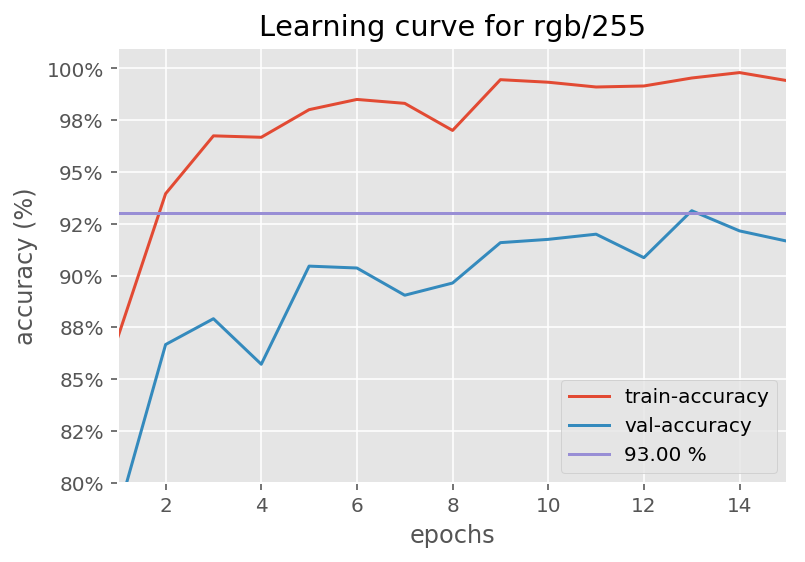

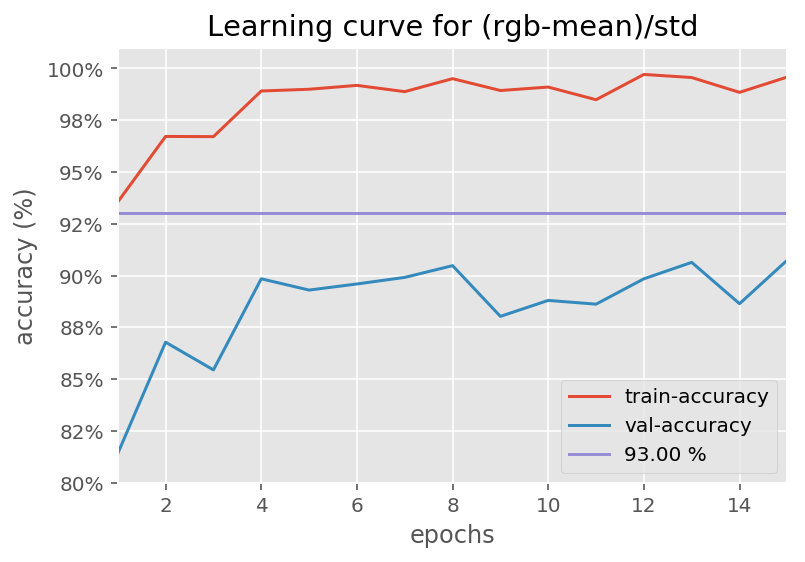

In [21]:
draw_learning_curve(learning_curves)

Looking at above result, it's hard to decide whether we should use normalized inputs or not since validation-accuracy are similar (both are still very overfitting). However we notice that training-accuracy with normalized inputs converge quicker. So we will use normalized input from now on.

Now let's tackle the over-fitting issue. One can do the following steps
* using drop-out layer
* train with more data: so we can try the augmented data

#### Experiment 3: Drop-out layer

Let's try adding drop-out to our model after each fully-connected layer's activation to see whether if it helps in preventing overfitting

In [22]:
def make_network_2(input_shape):
    return (NeuralNetwork()
                    .input(input_shape) 
                    .conv(ksize=(5, 5), out_channels=8, padding='VALID') 
                    .max_pool(ksize=2, stride=2)              
                    .conv(ksize=(5, 5), out_channels=16, padding='VALID')  
                    .max_pool(ksize=2, stride=2)              
                    .flatten()
                    .dense(120)
                    .dropout(0.5)
                    .dense(84)
                    .dropout(0.5)
                    .classifier(n_classes))

Let's try dropout with original data

In [23]:
# try dropout with original data
learning_curves_nn2 = evaluate_pipeline([('nn2 dropout', data_pipeline_3)], 
                                            make_network_2, epochs = 15)

--------------------------------------
Evaluate data pipeline nn2 dropout
--------------------------------------
Epoch (  1/15 ) Training-accuracy     80.04% 	Validation-accuracy 74.74% 	Running 4.50 seconds/batch
Epoch (  2/15 ) Training-accuracy     91.64% 	Validation-accuracy 85.22% 	Running 4.31 seconds/batch
Epoch (  3/15 ) Training-accuracy     94.72% 	Validation-accuracy 88.05% 	Running 3.67 seconds/batch
Epoch (  4/15 ) Training-accuracy     96.07% 	Validation-accuracy 89.93% 	Running 3.97 seconds/batch
Epoch (  5/15 ) Training-accuracy     97.55% 	Validation-accuracy 90.66% 	Running 3.96 seconds/batch
Epoch (  6/15 ) Training-accuracy     97.59% 	Validation-accuracy 92.18% 	Running 3.45 seconds/batch
Epoch (  7/15 ) Training-accuracy     98.38% 	Validation-accuracy 92.65% 	Running 3.40 seconds/batch
Epoch (  8/15 ) Training-accuracy     98.68% 	Validation-accuracy 93.90% 	Running 3.28 seconds/batch
Epoch (  9/15 ) Training-accuracy     98.57% 	Validation-accuracy 92.13% 	Runni

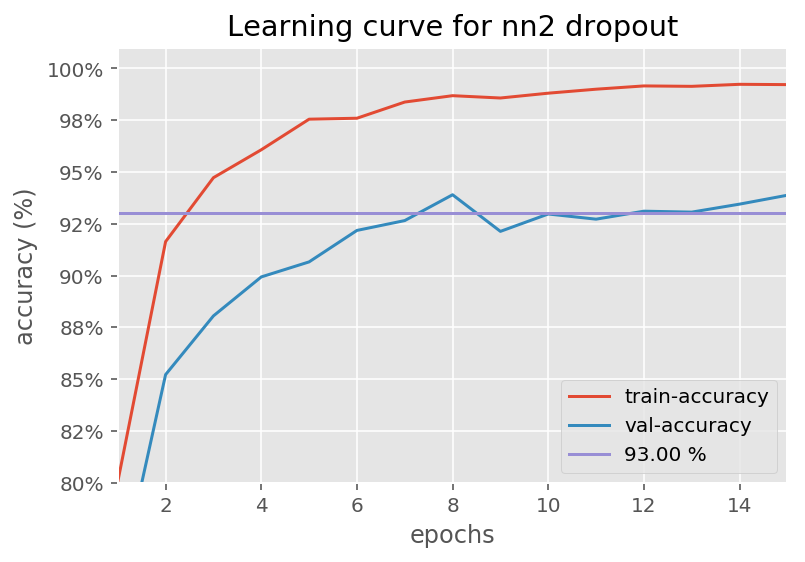

In [24]:
draw_learning_curve(learning_curves_nn2)

Our model finally passed the 93%, but it's clear that it still overfitting. 

|          | train   | validation | test  |
|:--------:|:-------:|:----------:|:-----:|
| original |  99.22  |   93.88    | 93.67 |


#### Experiment 4: Training with augmented dataset

Next, let's try it with augmented data, we still use the network with drop-out layer

In [25]:
learning_curves_nn2_aug_5x = evaluate_pipeline([('nn2 + aug_5x', data_pipeline_3)], 
                                               make_network_2, 
                                               src='aug_5x', epochs = 15)  

learning_curves_nn2_aug_3k = evaluate_pipeline([('nn2 + aug_3k', data_pipeline_3)], 
                                               make_network_2, 
                                               src='aug_3k', epochs = 15)

--------------------------------------
Evaluate data pipeline nn2 + aug_5x
--------------------------------------
Epoch (  1/15 ) Training-accuracy     78.55% 	Validation-accuracy 82.24% 	Running 21.61 seconds/batch
Epoch (  2/15 ) Training-accuracy     86.86% 	Validation-accuracy 88.91% 	Running 20.98 seconds/batch
Epoch (  3/15 ) Training-accuracy     89.59% 	Validation-accuracy 91.11% 	Running 25.14 seconds/batch
Epoch (  4/15 ) Training-accuracy     90.95% 	Validation-accuracy 93.58% 	Running 23.59 seconds/batch
Epoch (  5/15 ) Training-accuracy     92.59% 	Validation-accuracy 93.51% 	Running 23.72 seconds/batch
Epoch (  6/15 ) Training-accuracy     93.39% 	Validation-accuracy 94.72% 	Running 25.81 seconds/batch
Epoch (  7/15 ) Training-accuracy     93.14% 	Validation-accuracy 93.27% 	Running 23.88 seconds/batch
Epoch (  8/15 ) Training-accuracy     93.66% 	Validation-accuracy 93.33% 	Running 21.88 seconds/batch
Epoch (  9/15 ) Training-accuracy     94.55% 	Validation-accuracy 95.2

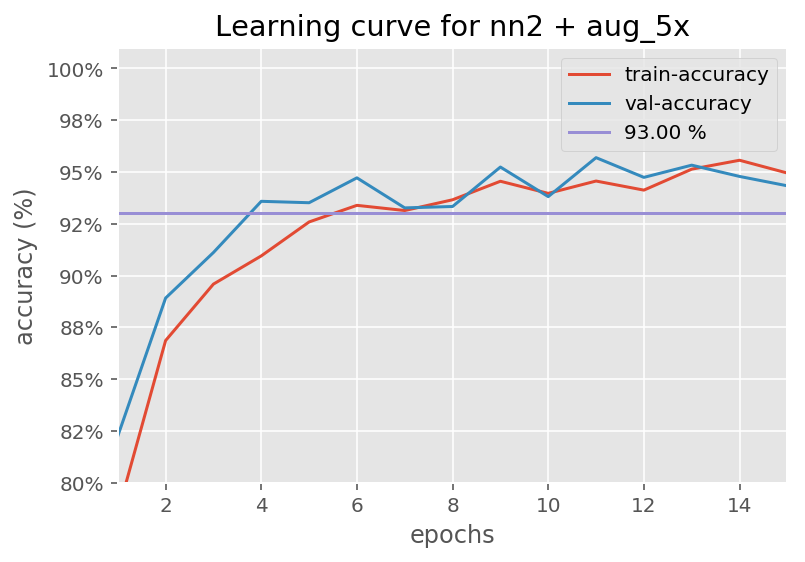

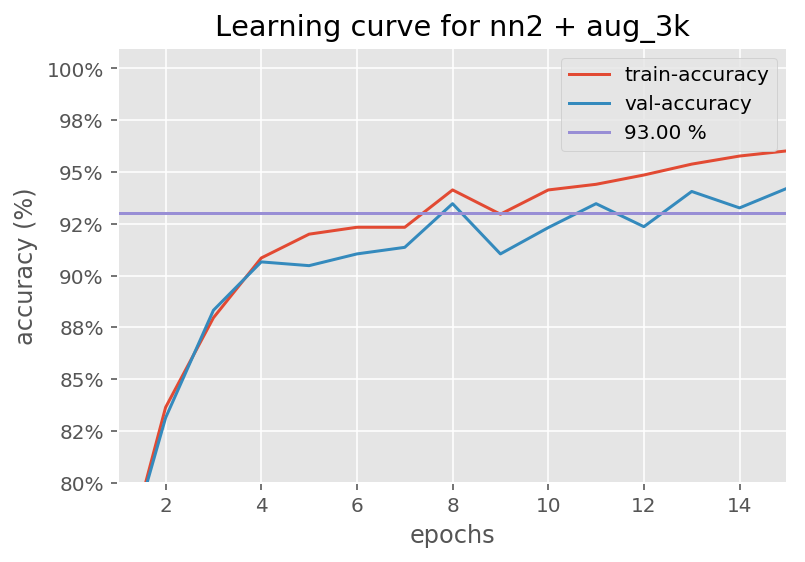

In [26]:
draw_learning_curve(learning_curves_nn2_aug_5x + learning_curves_nn2_aug_3k)

Oberserving above result, we can see that drop-out + augmented data is very effective at preventing overfitting the learning curve for training and validation accuracy are closer. The accuracy after training is given as belows

|                 | train   | validation | test  |
|:---------------:|:-------:|:----------:|:-----:|
| augmentation 5x |  94.95  |   94.33    | 94.18 |
| augmentation 3k |  96.02  |   94.22    | 92.82 |


#### Experiment 5: try with 100 epochs
Looking at the learning curve above, it looks like it hasn't converged yet. Let's try with 100 epochs

In [41]:
learning_curves_nn2_aug_5x_100 = evaluate_pipeline([('nn2 + aug_5x + 100 epochs', data_pipeline_3)], 
                                                   make_network_2, 
                                                   src='aug_5x', epochs=100, print_every=10)

--------------------------------------
Evaluate data pipeline nn2 + aug_5x + 100 epochs
--------------------------------------
Epoch (  1/100) Training-accuracy     75.56% 	Validation-accuracy 80.84% 	Running 19.29 seconds/batch
Epoch ( 10/100) Training-accuracy     94.44% 	Validation-accuracy 95.44% 	Running 16.14 seconds/batch
Epoch ( 20/100) Training-accuracy     95.46% 	Validation-accuracy 96.24% 	Running 27.04 seconds/batch
Epoch ( 30/100) Training-accuracy     96.38% 	Validation-accuracy 96.21% 	Running 27.25 seconds/batch
Epoch ( 40/100) Training-accuracy     96.43% 	Validation-accuracy 96.60% 	Running 26.23 seconds/batch
Epoch ( 50/100) Training-accuracy     96.63% 	Validation-accuracy 96.44% 	Running 26.37 seconds/batch
Epoch ( 60/100) Training-accuracy     96.06% 	Validation-accuracy 96.98% 	Running 26.67 seconds/batch
Epoch ( 70/100) Training-accuracy     97.14% 	Validation-accuracy 96.80% 	Running 26.75 seconds/batch
Epoch ( 80/100) Training-accuracy     97.24% 	Validation-

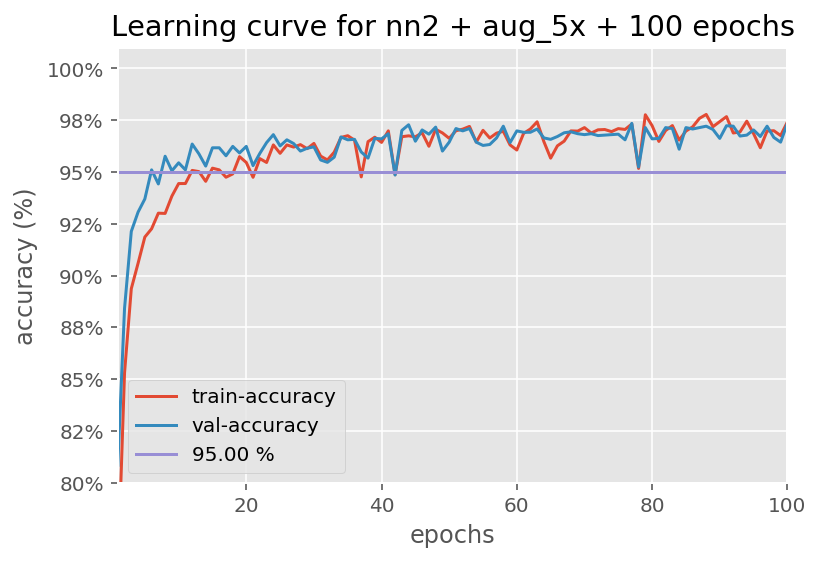

In [42]:
draw_learning_curve(learning_curves_nn2_aug_5x_100, base_levels=[.95])

With 100 epochs we obtain a slightly better accuracy

|                 | train   | validation | test  |
|:---------------:|:-------:|:----------:|:-----:|
| augmentation 5x |  97.41  |   97.35    | 94.62 |

We observe that our learning-curve is not improving after 40 epochs and training-accuracy is fluctuating, one could try a lower learning rate

#### Experiment 6: try a lower learning-rate
Currently we use default `learning_rate=1e-3`, let's try `learning_rate=5e-4` with 100 epochs

In [43]:
learning_curves_nn2_aug_5x_100_5e4 = evaluate_pipeline([('nn2 + aug_5x + 100 epochs + lr=5e-4', 
                                                         data_pipeline_3)], 
                                                       make_network_2, 
                                                       src='aug_5x', epochs=100, print_every=10, 
                                                       learning_rate=5e-4)

--------------------------------------
Evaluate data pipeline nn2 + aug_5x + 100 epochs + lr=5e-4
--------------------------------------
Epoch (  1/100) Training-accuracy     69.58% 	Validation-accuracy 75.08% 	Running 24.98 seconds/batch
Epoch ( 10/100) Training-accuracy     93.57% 	Validation-accuracy 94.15% 	Running 27.00 seconds/batch
Epoch ( 20/100) Training-accuracy     95.47% 	Validation-accuracy 94.97% 	Running 26.85 seconds/batch
Epoch ( 30/100) Training-accuracy     96.46% 	Validation-accuracy 95.42% 	Running 26.69 seconds/batch
Epoch ( 40/100) Training-accuracy     96.85% 	Validation-accuracy 96.46% 	Running 26.52 seconds/batch
Epoch ( 50/100) Training-accuracy     97.52% 	Validation-accuracy 96.15% 	Running 26.65 seconds/batch
Epoch ( 60/100) Training-accuracy     97.91% 	Validation-accuracy 96.35% 	Running 26.59 seconds/batch
Epoch ( 70/100) Training-accuracy     97.82% 	Validation-accuracy 96.08% 	Running 27.30 seconds/batch
Epoch ( 80/100) Training-accuracy     97.95% 	V

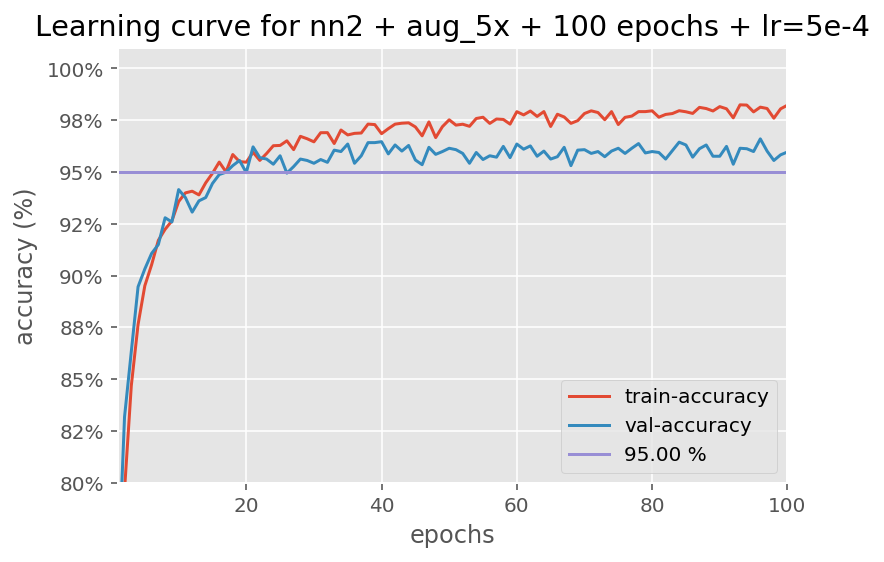

In [45]:
draw_learning_curve(learning_curves_nn2_aug_5x_100_5e4, base_levels=[.95])

Using `learning_rate=5e-4`, not only the learning-curves are smoother and we obtain a better training accuracy, however validation accuracy is worse

|                 | train   | validation | test  |
|:---------------:|:-------:|:----------:|:-----:|
| augmentation 5x |  98.22  |   95.96    | 95.35 |


We think this might be the best that the current model can do. We might need other net to improve the accuracy further.

#### Experiment 7: try out the baseline model's architecture

Since the baseline model gives a very high accuracy > 98%, it might be worth to try it out. Let's use

* 2 layer conv-net 108-108 filters each
* multi-scale features: concatenate features from the first conv-layer (after max-pool 4x4) and the second one
* we use only one fc-layer of 100 hidden units as suggested in the baseline model

The training parameters are
<center>`learning_rate=5e-4` and `epochs=100`</center>


In [51]:
def make_network_3(input_shape):
    return (NeuralNetwork()
                    .input(input_shape) 
                    .conv(ksize=(5, 5), out_channels=108, padding='VALID') 
                    .max_pool(ksize=2, stride=2)              
                    .conv(ksize=(5, 5), out_channels=108, padding='VALID')  
                    .max_pool(ksize=2, stride=2)              
                    .multi_scale(layer_ids = ['conv_1', 'conv_2'], max_pools=[(4,4), None])
                    .dense(100)
                    .dropout(0.5)
                    .classifier(n_classes))

We will test this neural net with RGB normalized vs Y normalized as suggested in the baseline model's paper

In [52]:
# convert to grayscale Y, then normalize it
data_pipeline_4   = TransformPipeline([trans_rgb_y, trans_standard])


learning_curves_5x_nn3 = evaluate_pipeline([('rgb + nn3 + aug_5x', data_pipeline_3), 
                                            ('y + nn3 + aug_5x',   data_pipeline_4)], 
                                            make_network_3, 
                                            src='aug_5x', 
                                            epochs = 100, print_every=10, batch_size=128,
                                            learning_rate = 5e-4)

--------------------------------------
Evaluate data pipeline rgb + nn3 + aug_5x
--------------------------------------
Epoch (  1/100) Training-accuracy     89.84% 	Validation-accuracy 91.07% 	Running 27.19 seconds/batch
Epoch ( 10/100) Training-accuracy     99.49% 	Validation-accuracy 96.73% 	Running 28.57 seconds/batch
Epoch ( 20/100) Training-accuracy     99.73% 	Validation-accuracy 96.60% 	Running 29.16 seconds/batch
Epoch ( 30/100) Training-accuracy     99.85% 	Validation-accuracy 96.60% 	Running 28.62 seconds/batch
Epoch ( 40/100) Training-accuracy     99.93% 	Validation-accuracy 97.23% 	Running 27.23 seconds/batch
Epoch ( 50/100) Training-accuracy     99.94% 	Validation-accuracy 97.48% 	Running 26.51 seconds/batch
Epoch ( 60/100) Training-accuracy     99.86% 	Validation-accuracy 97.41% 	Running 27.35 seconds/batch
Epoch ( 70/100) Training-accuracy     99.87% 	Validation-accuracy 97.71% 	Running 26.95 seconds/batch
Epoch ( 80/100) Training-accuracy     99.94% 	Validation-accurac

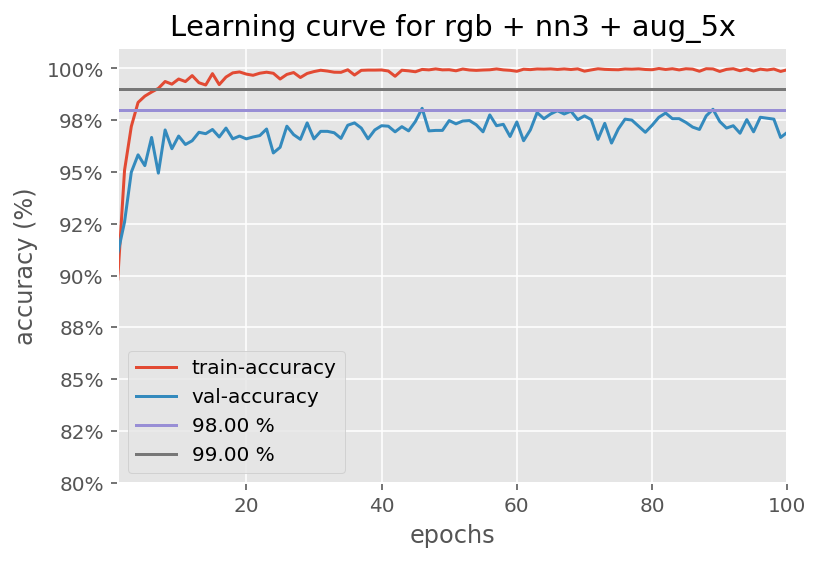

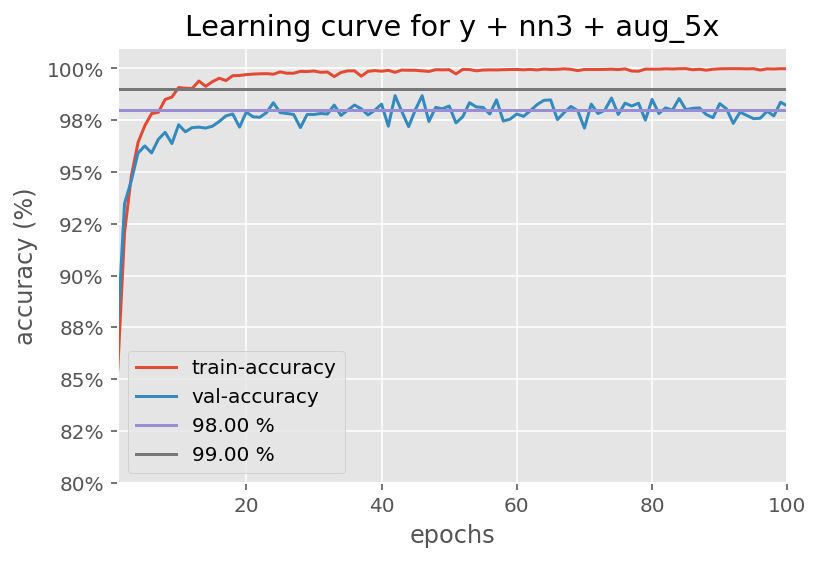

In [101]:
draw_learning_curve(learning_curves_5x_nn3, base_levels=[.98, .99])

Observe above result, one can see that Y performs better than RGB for this architecture. The accuracy table is given as belows

|     | train   | validation | test  |
|:---:|:-------:|:----------:|:-----:|
| RGB |  99.94  |   96.92    | 96.79 |
| Y   |  99.98  |   98.19    | 97.19 |

This multi-scale architecture works well with grayscale image, we finally obtain validation accuracy > 98%.

#### Experiment 8: try early stopping
Looking at validation accuracy, it reaches its highest before training done, we can use that as final state instead of the one after 100 epochs

In [104]:
learning_curves_5x_nn3_early = evaluate_pipeline([('y + nn3 + aug_5x + early_stopping', data_pipeline_4)], 
                                                 make_network_3, 
                                                 src='aug_5x', 
                                                 epochs = 100, print_every=10,
                                                 learning_rate = 5e-4, 
                                                 early_stopping = True, early_checkpoint = 'y_nn3_aug5x_early.cpkt')

--------------------------------------
Evaluate data pipeline y + nn3 + aug_5x + early_stopping
--------------------------------------
Epoch (  1/100) Training-accuracy     85.13% 	Validation-accuracy 86.92% 	Running 32.06 seconds/batch
Epoch ( 10/100) Training-accuracy     98.52% 	Validation-accuracy 97.14% 	Running 32.25 seconds/batch
Epoch ( 20/100) Training-accuracy     99.30% 	Validation-accuracy 97.10% 	Running 32.17 seconds/batch
Epoch ( 30/100) Training-accuracy     99.64% 	Validation-accuracy 97.26% 	Running 32.11 seconds/batch
Epoch ( 40/100) Training-accuracy     99.79% 	Validation-accuracy 96.83% 	Running 30.70 seconds/batch
Epoch ( 50/100) Training-accuracy     99.84% 	Validation-accuracy 97.05% 	Running 29.59 seconds/batch
Epoch ( 60/100) Training-accuracy     99.86% 	Validation-accuracy 97.51% 	Running 27.80 seconds/batch
Epoch ( 70/100) Training-accuracy     99.89% 	Validation-accuracy 97.26% 	Running 30.21 seconds/batch
Epoch ( 80/100) Training-accuracy     99.95% 	Val

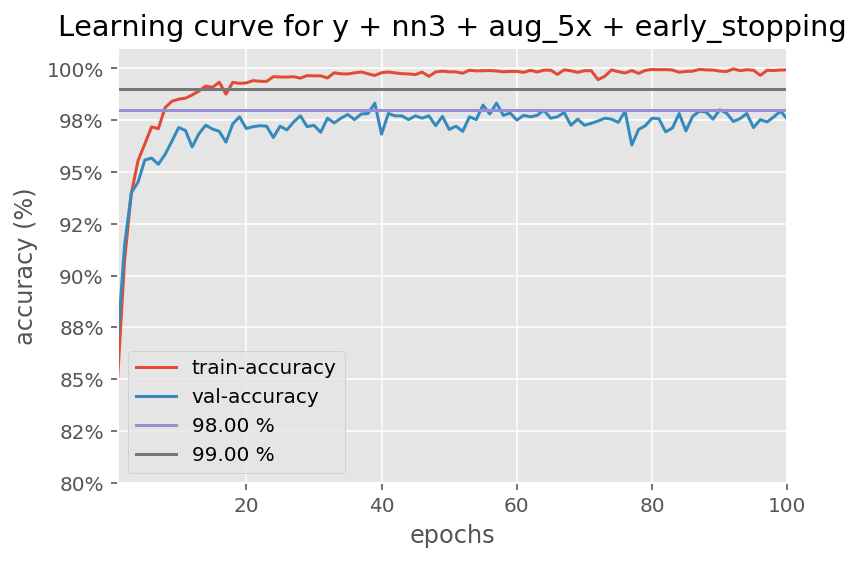

In [106]:
draw_learning_curve(learning_curves_5x_nn3_early, base_levels=[.98, .99])

The early stopping have the following accuracy

|     | train   | validation | test  |
|:---:|:-------:|:----------:|:-----:|
| Y   |  99.66  |   98.32    | 96.24 |

We will use this as our final model.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

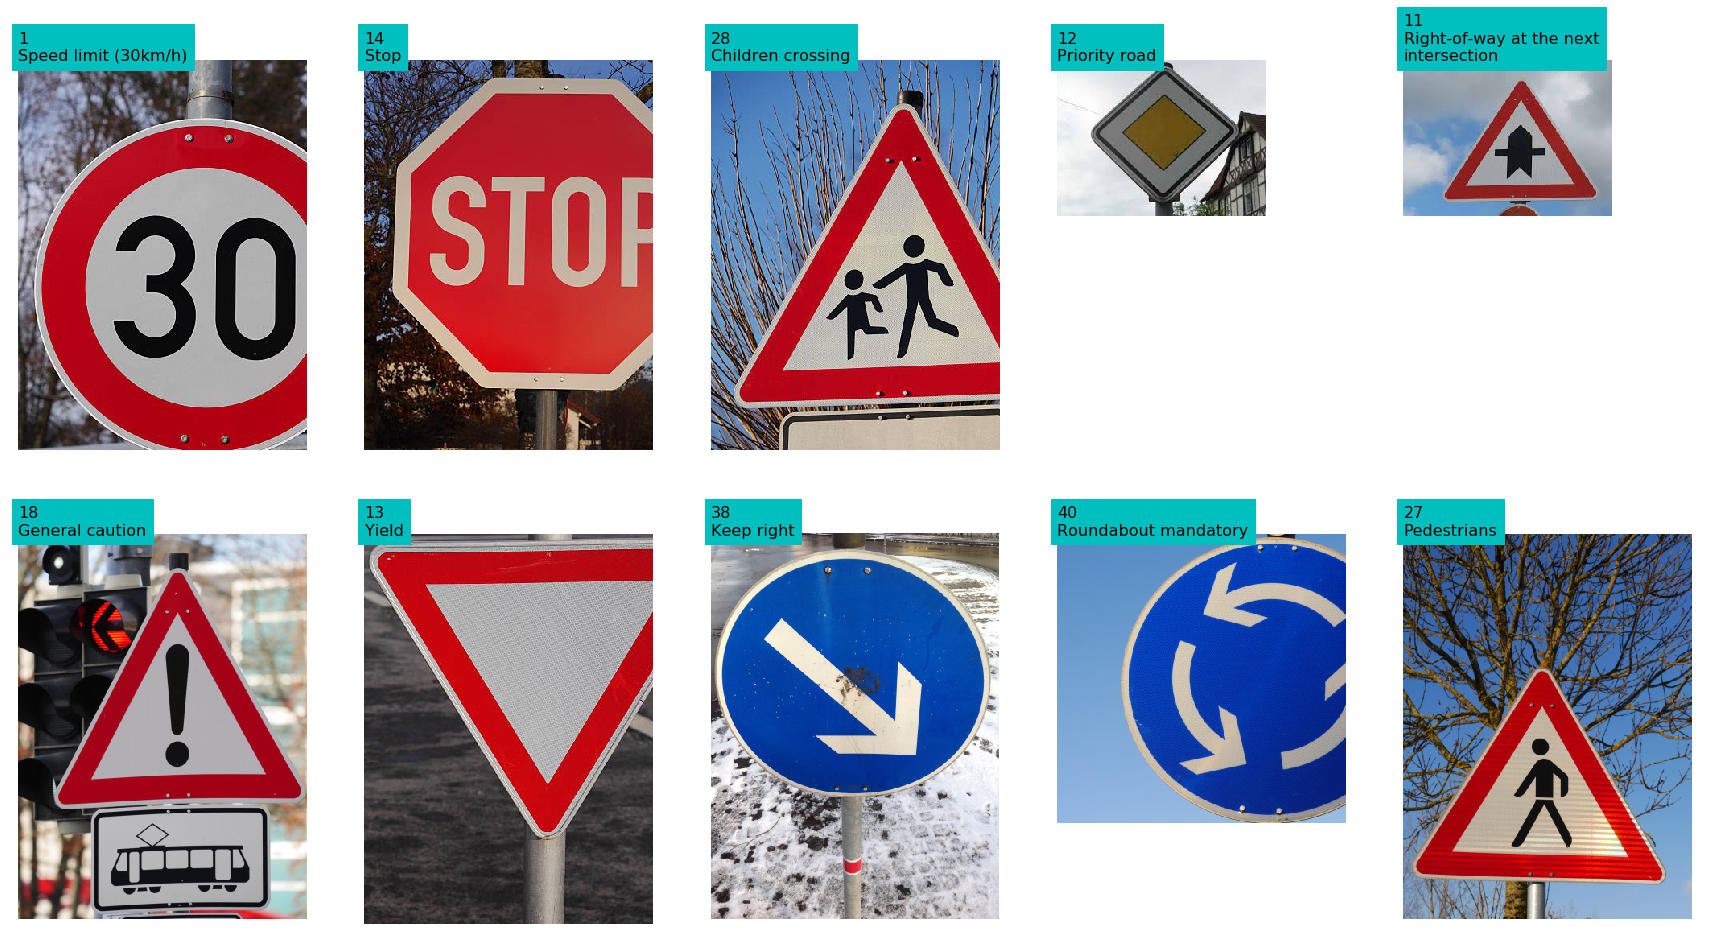

In [105]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import pandas as pd

test_dir   = "./assets/test_images"
new_imgs   = []
new_labels = []

test_data = pd.read_csv(os.path.join(test_dir, 'test_imgs_labels.csv'))
# load test images
for fn,label in test_data[['img_file', 'label']].values:    
    img = mpimg.imread(os.path.join(test_dir, fn))    
        
    new_imgs.append(img)    
    new_labels.append(label)

new_labels = np.array(new_labels)
# visualize it
grid_view(new_imgs, new_labels, SIGNAMES, ncols=5, figsize=(15,8))

Note that our model only accept image size of (32, 32, 3), we will use tf.image.resize to convert images to correct input size

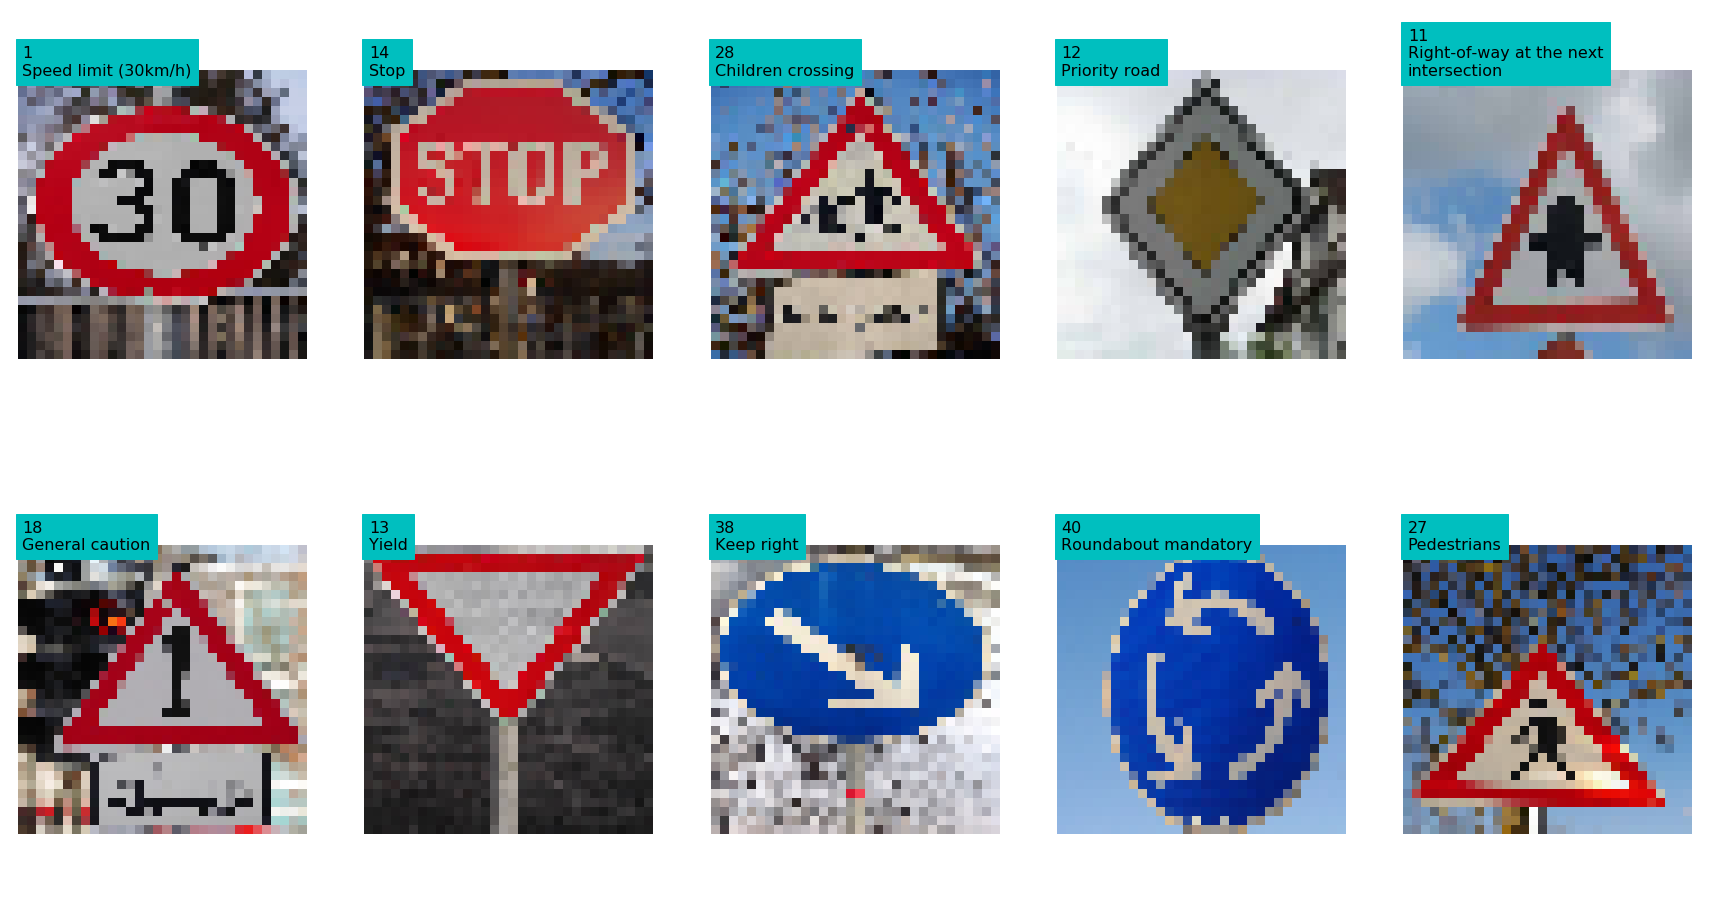

In [89]:
resize_32x32 = lambda x:cv2.resize(x, (32, 32))
    
new_imgs_scaled = [resize_32x32(img) for img in new_imgs]   
grid_view(new_imgs_scaled, new_labels, SIGNAMES, ncols=5, figsize=(15,8))

### Predict the Sign Type for Each Image

In [169]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

def predict(imgs, net, check_point):
    with TrainingSession(net, auto_save = False) as sess:
        sess.load(check_point)
        return sess.predict(imgs)

# since we use data_pipeline_4 + aug_5x
ds_3 = make_dataset(data_pipeline_3, src = 'aug_5x')
ds_4 = make_dataset(data_pipeline_4, src = 'aug_5x')

### Analyze Performance

In [145]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
new_inputs, _ = ds_4.transform(np.array(new_imgs_scaled))

preds = predict(new_inputs, make_network_3(new_inputs.shape[1:]), './checkpoints/y_nn3_aug5x_early.cpkt')
print('true-label: {}'.format(new_labels))
print('prediction: {}'.format(preds))

accuracy = np.mean(preds == new_labels)

print('Accuracy for new images: {:.2f}%'.format(100*accuracy))

true-label: [ 1 14 28 12 11 18 13 38 40 27]
prediction: [ 1 14 23 12 11 18 13 38 40 27]
Accuracy for new images: 90.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

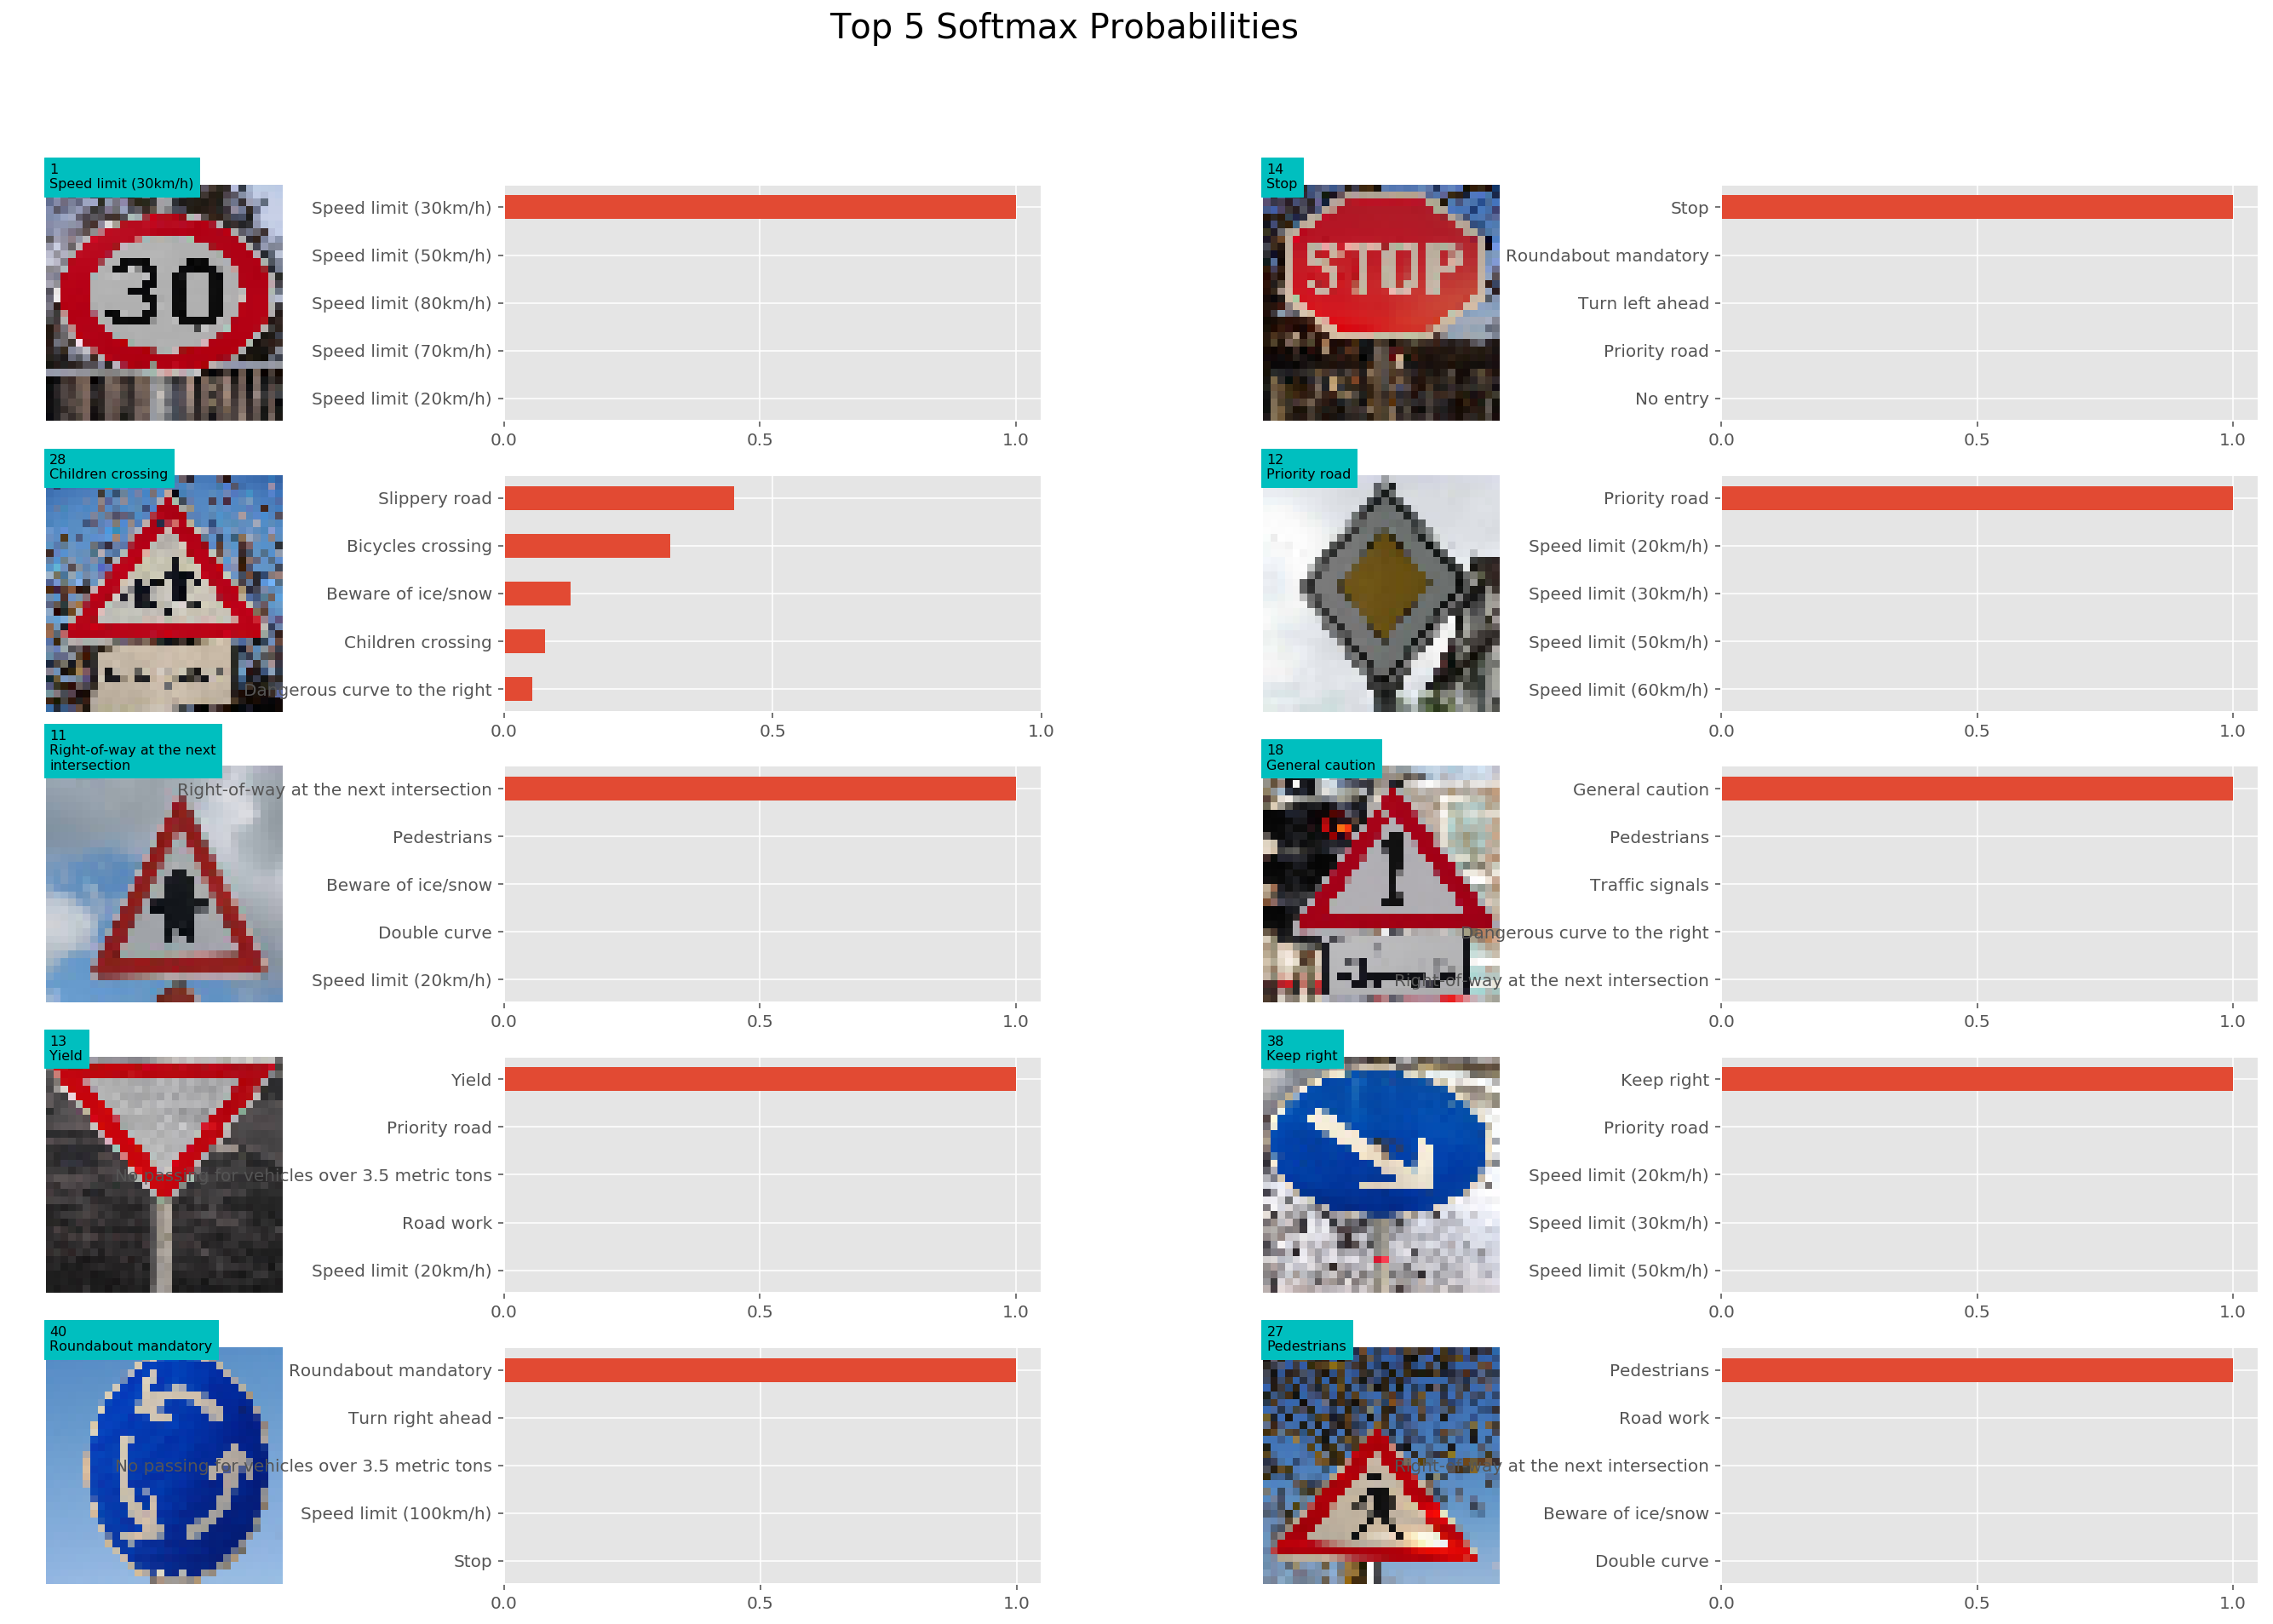

In [144]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
def top_k(imgs, net, check_point):
    with TrainingSession(net, auto_save = False) as sess:
        sess.load(check_point)
        return sess.top_k(imgs)

def visualize_top_k(imgs, labels, top_k):
    '''
    visualize each image with true label + top-k probability
    '''
    top_k_probs, top_k_labels = top_k
    
    num_imgs = (len(imgs)+1) // 2
    fig, axies = plt.subplots(nrows=num_imgs, ncols=4, figsize = (20,12))
    fig.tight_layout()
    fig.suptitle('Top 5 Softmax Probabilities', fontsize=20, y=1.1)
    
    # some style
    n_predictions = 5
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
    
    for i, (img, label) in enumerate(zip(imgs, labels)):
        j = i % 2
        axe_i = i//2
        show_img(img, label, signame = SIGNAMES[label], ax = axies[axe_i][2*j])
        #axies[i][0].imshow(img)
        pred_names = [SIGNAMES[pred_i] for pred_i in top_k_labels[i]]
        axies[axe_i][2*j+1].barh(ind + margin, top_k_probs[i][::-1], 0.5)
        axies[axe_i][2*j+1].set_yticks(ind + margin)
        axies[axe_i][2*j+1].set_yticklabels(pred_names[::-1])
        axies[axe_i][2*j+1].set_xticks([0, 0.5, 1.0])
        
top_k_pred = top_k(new_inputs, make_network_3(new_inputs.shape[1:]), './checkpoints/y_nn3_aug5x_early.cpkt')

visualize_top_k(new_imgs_scaled, new_labels, top_k_pred)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [190]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# features: should be a layer's output
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def visualize_features(features, activation_min=-1, activation_max=-1 ,plt_num=1, figsize=(15,15)):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    featuremaps = features.shape[2]
    fig = plt.figure(plt_num, figsize=figsize)
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap), fontsize=10) # displays the feature map number
        vmin = None if activation_min==-1 else activation_min
        vmax = None if activation_max==-1 else activation_max
        plt.imshow(features[:,:, featuremap], 
                   interpolation="nearest", 
                   vmin=vmin, vmax=vmax, cmap="gray")
        plt.axis('off')

We will visualize using LeNet5 architecture since it has less layers 8 v.s 108 in the multi-scale

In [208]:
def get_layers(img, net, check_point, layer_ids):
    with TrainingSession(net, auto_save = False) as sess:
        sess.load(check_point)
        return sess.get_layers(img, layer_ids)

vis_inputs, _  = ds_3.transform(new_imgs_scaled)
conv_layers = get_layers(vis_inputs, 
                         make_network_2(vis_inputs.shape[1:]), 
                         '/tmp/tmpt9dxngmm',
                        ['conv_1', 'conv_2'])

Let's visualize features for `test01.jpg` and `test03.jpg`

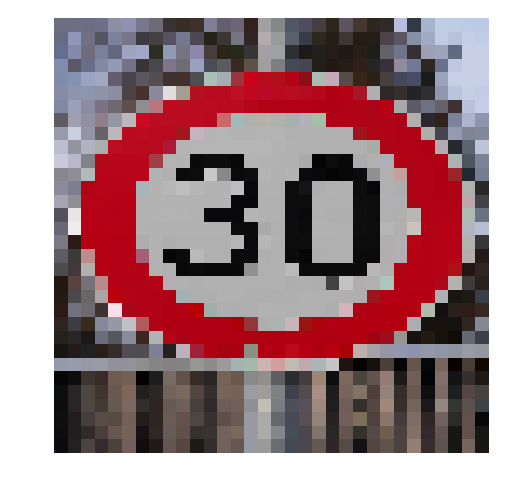

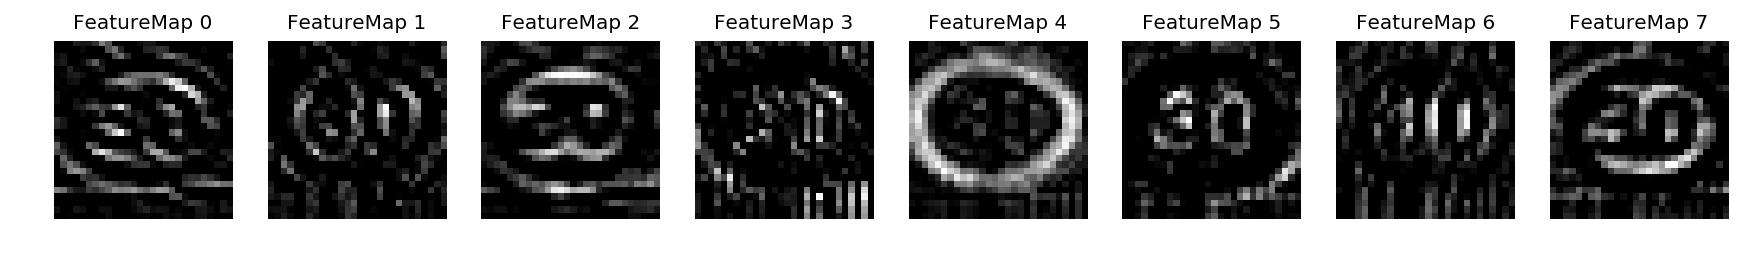

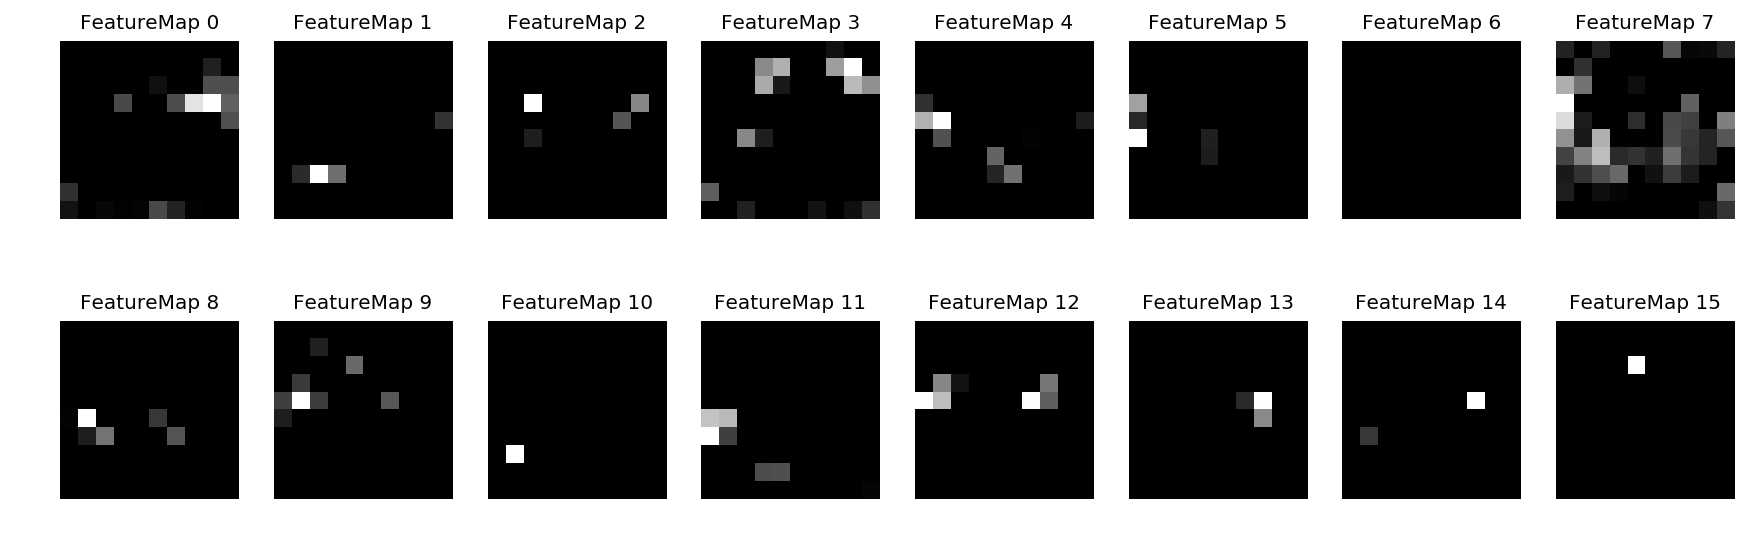

In [209]:
show_img(new_imgs_scaled[0], None)
visualize_features(conv_layers[0][0], plt_num=2)
visualize_features(conv_layers[1][0], plt_num=3)

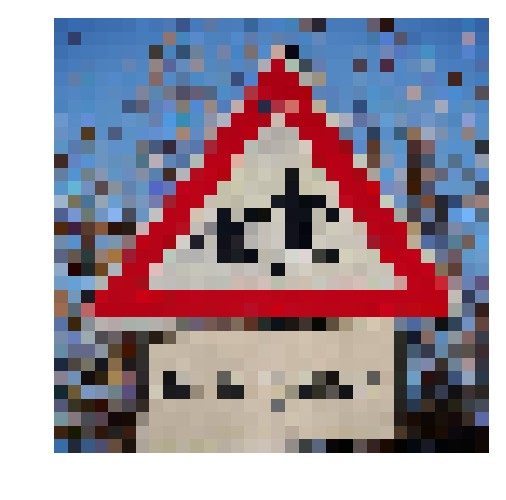

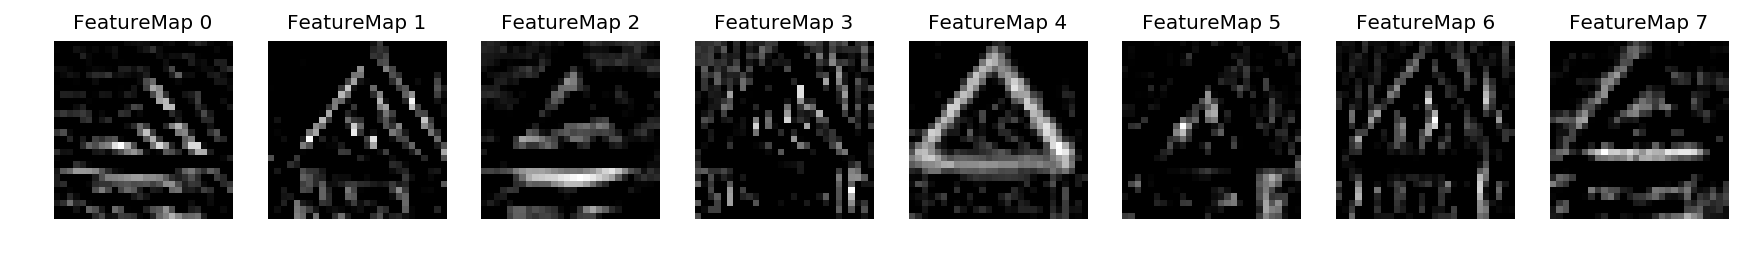

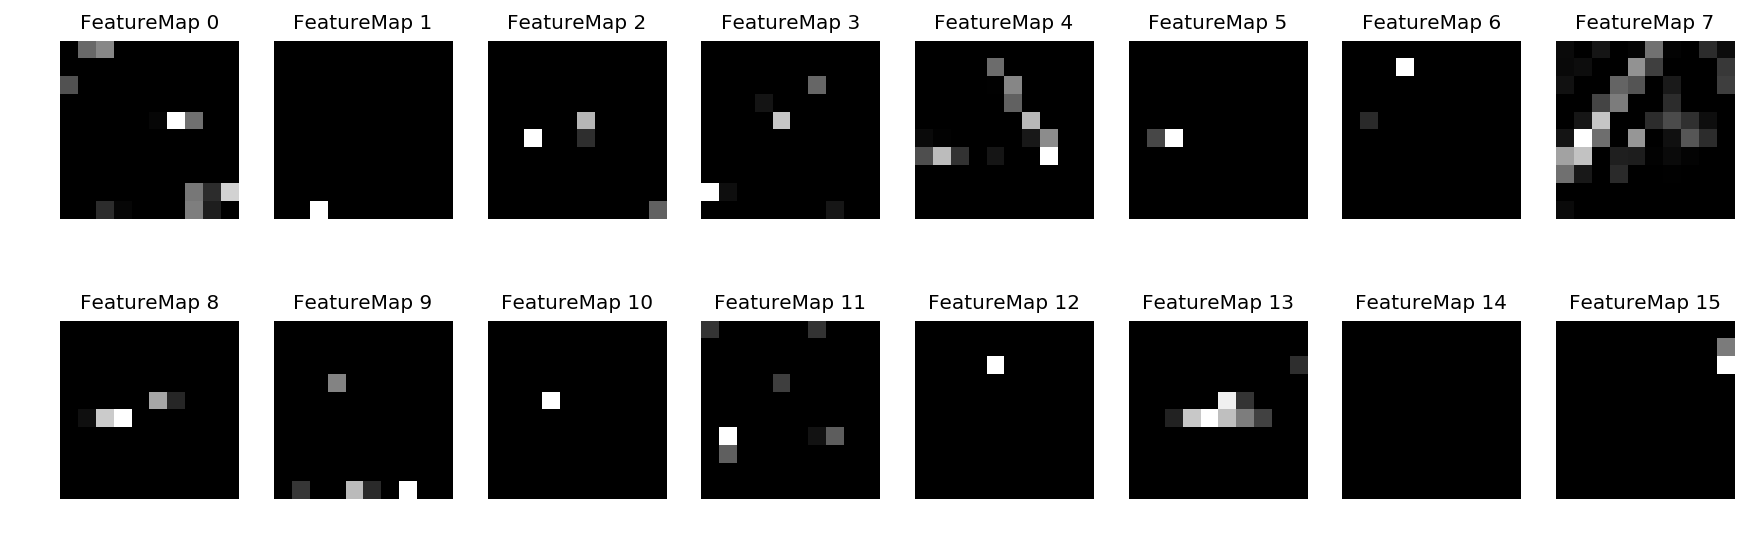

In [210]:
show_img(new_imgs_scaled[2], None)
visualize_features(conv_layers[0][2], plt_num=2)
visualize_features(conv_layers[1][2], plt_num=3)

We notice that the `FeatureMap 4` of the first layer seem to be activated via shape, the second one is not easy to interpretable. Now let's look an image that has a lot of traffic sign in it and an image that has a dog

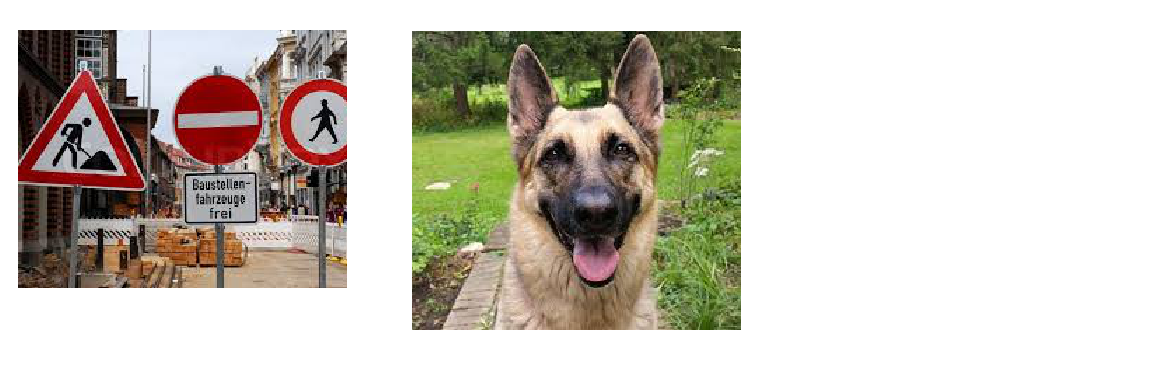

In [203]:
vis_imgs = [ mpimg.imread('./assets/vis_images/vis_example01.jpg'),
             mpimg.imread('./assets/vis_images/vis_example02.jpg')]

grid_view(vis_imgs, [None, None], figsize=(10,3))

vis_img_scaled = np.array([resize_32x32(vis_img) for vis_img in vis_imgs])

vis_inputs, _  = ds_3.transform(vis_img_scaled)
vis_conv_layers = get_layers(vis_inputs, make_network_2(vis_inputs.shape[1:]), 
                             '/tmp/tmpt9dxngmm',
                             ['conv_1', 'conv_2'])

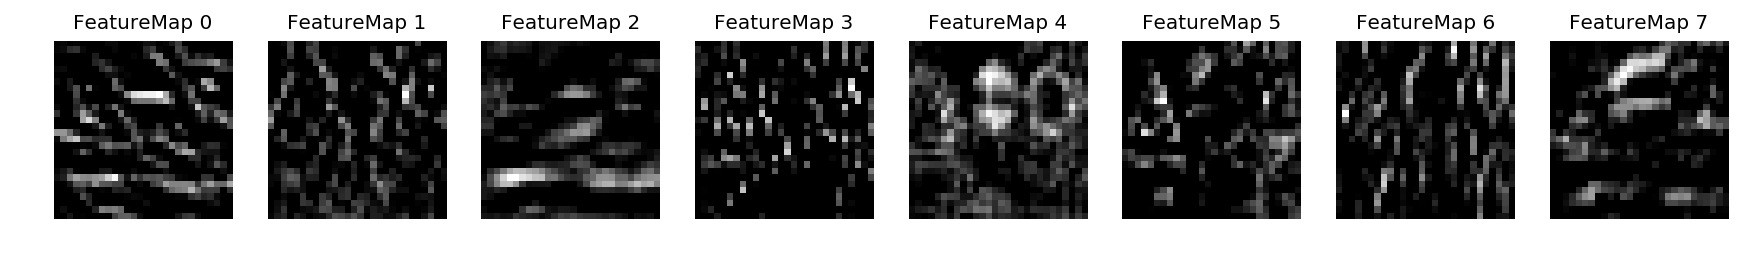

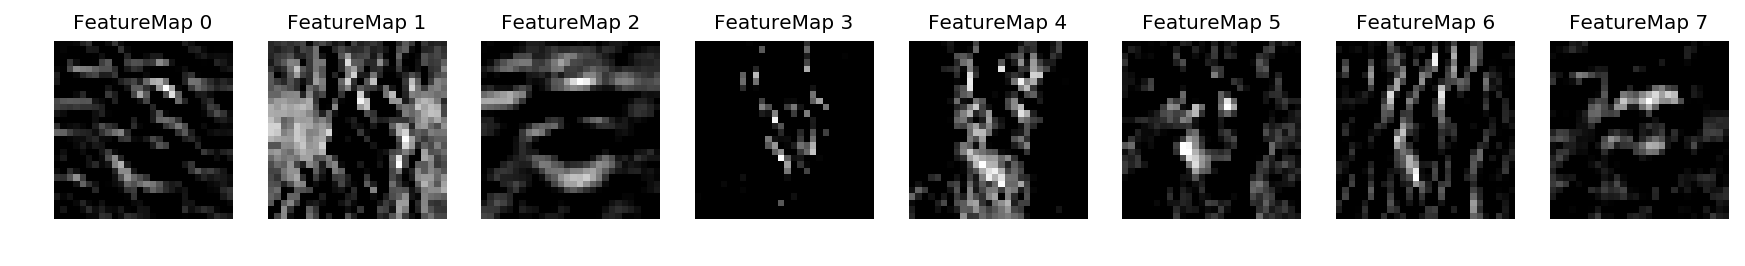

In [205]:
visualize_features(vis_conv_layers[0][0], plt_num=1)
visualize_features(vis_conv_layers[0][1], plt_num=2)

The first layer looks more noisy than before but looking at `FeatureMap 4`, it still looks like shape of the front image.

In the scope of this project, we won't look further on visualizing deep layers but if you are interested there are few interesting papers on this
* Understanding Neural Networks Through Deep Visualization by [Yosinski et al.](http://www.evolvingai.org/files/2015_Yosinski_ICML.pdf)
* Visualizing and Understanding Convolutional Networks by [Zeiler  et al.](https://www.cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)